### Task 1 Generate the network of interest

In [42]:
#Define Network name. (Set a unique name for the generated network graph downloaded from OSM)
network_name = 'porto_whole1' 

#Essential function to save graph in special format for FMM
def save_graph_shapefile_directional(G, filepath=None, encoding="utf-8"):
    # default filepath if none was provided
    if filepath is None:
        filepath = os.path.join(ox.settings.data_folder, "graph_shapefile")

    # if save folder does not already exist, create it (shapefiles
    # get saved as set of files)
    if not filepath == "" and not os.path.exists(filepath):
        os.makedirs(filepath)
    filepath_nodes = os.path.join(filepath, "nodes.shp")
    filepath_edges = os.path.join(filepath, "edges.shp")

    # convert undirected graph to gdfs and stringify non-numeric columns
    gdf_nodes, gdf_edges = ox.utils_graph.graph_to_gdfs(G)
    gdf_nodes = ox.io._stringify_nonnumeric_cols(gdf_nodes)
    gdf_edges = ox.io._stringify_nonnumeric_cols(gdf_edges)
    # We need an unique ID for each edge
    gdf_edges["fid"] = np.arange(0, gdf_edges.shape[0], dtype='int')

    # save the nodes and edges as separate ESRI shapefiles
    gdf_nodes.to_file(filepath_nodes, encoding=encoding)
    gdf_edges.to_file(filepath_edges, encoding=encoding)

print("osmnx version",ox.__version__)


osmnx version 1.2.2


C:\Users\guang\AppData\Local\Temp\ipykernel_12748\3370477385.py:25: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_nodes.to_file(filepath_nodes, encoding=encoding)


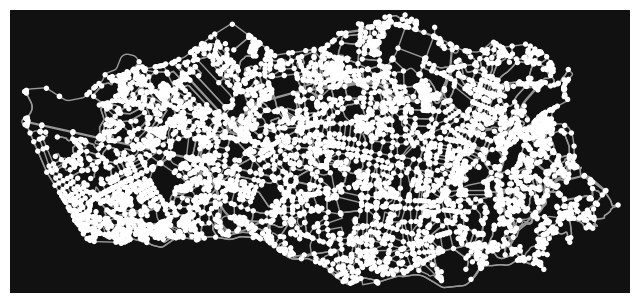

--- 20.45261812210083 seconds ---


In [43]:
#Method 1. (download the entire porto network based on the polylines provided by OSM)
#Save graph to use as input for cyang's FMM (Extract Whole Porto)

#change the place as required. 
place ="Porto, Portugal"

import osmnx as ox
import time
from shapely.geometry import Polygon
import os
import numpy as np
%matplotlib inline


start_time = time.time()
G2 = ox.graph_from_place(place, network_type='drive')
save_graph_shapefile_directional(G2, filepath='./' + network_name)
fig, ax = ox.plot_graph(G2)
ox.save_graphml(G, filepath = './' + network_name + '/saved_osmnx_graph')
print("--- %s seconds ---" % (time.time() - start_time))


In [ ]:
#Method 2. (download a much bigger map beyond porto to ensure all trajectory well covered)
#Save graph to use as input for cyang's FMM (Extra all relevant space that the train-1000.csv to perform fmm mapmatching)
#Method used to extract a bigger map for task 6
network_name = "porto_big"
import osmnx as ox
import time
from shapely.geometry import Polygon
import os
import numpy as np

%matplotlib inline
#bounds will be set to generate each graph of interest
#bounds = (18.01141, 18.02459, 59.32615, 59.32889)

#generate min/max x and min/max y using 4. below to analyze one individual trajectory
#bounds = (min_x - 0.002, max_x + 0.002, min_y - 0.002, max_y + 0.002)

#As per train-1000.csv. The min/max Lat is 41.008275/41.260086. The min/max Long is -8.709399/-8.486757
#bounds are described by min,max long followed by min,max lat 
start_time = time.time()
bounds = (-8.709399, -8.486757, 41.008275, 41.260086)
x1,x2,y1,y2 = bounds
boundary_polygon = Polygon([(x1,y1),(x2,y1),(x2,y2),(x1,y2)])
G = ox.graph_from_polygon(boundary_polygon, network_type='drive')
fig, ax = ox.plot_graph(G)
save_graph_shapefile_directional(G, filepath='./' + network_name)
ox.save_graphml(G, filepath = './' + network_name + '/saved_osmnx_graph')
print("--- %s seconds ---" % (time.time() - start_time))

In [295]:
import geopandas as gp
print("Show some sample edges from the graph")
edge_dataframe = gp.GeoDataFrame.from_file(network_name + "/edges.shp")

print("Total edges in the graph: ", len(edge_dataframe))
edge_dataframe[0:10]

Show some sample edges from the graph
Total edges in the graph:  73460


,u,v,key,osmid,oneway,highway,reversed,length,lanes,ref,...,bridge,name,width,access,junction,tunnel,service,area,fid,geometry
0,25503936,4722746638,0,479127843,1,motorway_link,False,32.388,None,None,...,None,None,None,None,None,None,None,None,0,"LINESTRING (-8.64064 41.16607, -8.64091 41.16628)"
1,25503936,281726624,0,4256507,1,motorway_link,False,224.655,None,None,...,None,None,None,None,None,None,None,None,1,"LINESTRING (-8.64064 41.16607, -8.64072 41.166..."
2,25503951,1243857957,0,4256513,1,motorway_link,False,115.105,1,IC 1,...,None,None,None,None,None,None,None,None,2,"LINESTRING (-8.64204 41.16835, -8.64234 41.168..."
3,25503951,4507024043,0,158906049,1,motorway_link,False,191.892,1,None,...,None,None,None,None,None,None,None,None,3,"LINESTRING (-8.64204 41.16835, -8.64222 41.168..."
4,25504027,1243857999,0,"[4256491, 108390772, 479127839]",1,motorway_link,False,118.915,"['2', '1']",None,...,yes,None,None,None,None,None,None,None,4,"LINESTRING (-8.64159 41.16689, -8.64173 41.167..."
5,25504163,25504183,0,"[479198379, 479198374]",1,trunk,False,77.190,3,"['EN 14', 'EN 14;EN 13']",...,None,Via Norte,None,None,None,None,None,None,5,"LINESTRING (-8.62241 41.17423, -8.62243 41.174..."
6,25504183,2486710630,0,"[479198378, 427967026]",1,trunk,False,272.900,4,"['EN 14', 'EN 14;EN 13']",...,None,Via Norte,None,None,None,None,None,None,6,"LINESTRING (-8.62244 41.17493, -8.62243 41.175..."
7,25507474,277530119,0,29043404,1,motorway_link,False,118.135,1,None,...,None,None,None,None,None,None,None,None,7,"LINESTRING (-8.56850 41.10195, -8.56951 41.10121)"
8,25507474,277537706,0,139462631,1,motorway_link,False,279.524,1,None,...,None,Nó de Vilar de Andorinho,None,None,None,None,None,None,8,"LINESTRING (-8.56850 41.10195, -8.56856 41.101..."
9,25507482,263912590,0,"[390157762, 390157763, 29043402, 29043512, 290...",1,motorway,False,744.938,"['2', '3']",A 20;IP 1,...,yes,None,None,None,None,None,None,None,9,"LINESTRING (-8.57186 41.09908, -8.57228 41.098..."


In [ ]:
import geopandas as gp
print("Show some sample nodes from the graph")
nodes_dataframe = gp.GeoDataFrame.from_file(network_name + "/nodes.shp")

print("Total nodes in the graph: ", len(nodes_dataframe))
nodes_dataframe.head()


### Task 2 Visualization of raw trip data

In [2]:
import matplotlib.pyplot as plt
import osmnx as ox
from descartes import PolygonPatch
from shapely.geometry import MultiPolygon
from shapely.geometry import Polygon
import pandas
import ast
import numpy as np

/Users/ming/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


/Users/ming/opt/anaconda3/lib/python3.8/site-packages/osmnx/utils_geo.py:326: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/Users/ming/opt/anaconda3/lib/python3.8/site-packages/osmnx/utils_geo.py:422: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/Users/ming/opt/anaconda3/lib/python3.8/site-packages/osmnx/utils_geo.py:431: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  points_within_geometry = points_within_geometry.append(precise_matches)
/Users/ming/opt/anaconda3/lib/python3.8/site-packages/osmnx/utils_geo.py:431: FutureWarning: The frame.append met

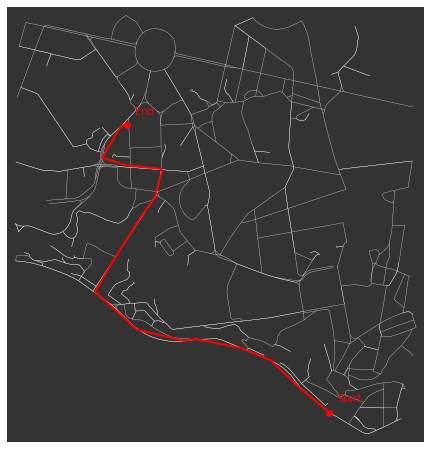

/Users/ming/opt/anaconda3/lib/python3.8/site-packages/osmnx/utils_geo.py:326: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/Users/ming/opt/anaconda3/lib/python3.8/site-packages/osmnx/utils_geo.py:422: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/Users/ming/opt/anaconda3/lib/python3.8/site-packages/osmnx/utils_geo.py:431: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  points_within_geometry = points_within_geometry.append(precise_matches)
/Users/ming/opt/anaconda3/lib/python3.8/site-packages/osmnx/utils_geo.py:431: FutureWarning: The frame.append met

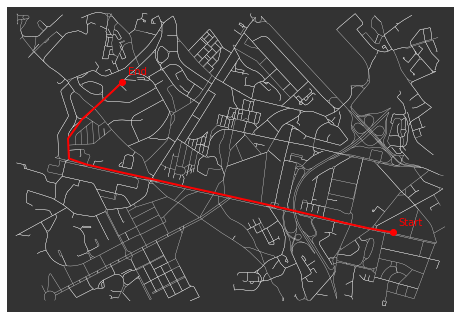

/Users/ming/opt/anaconda3/lib/python3.8/site-packages/osmnx/utils_geo.py:326: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/Users/ming/opt/anaconda3/lib/python3.8/site-packages/osmnx/utils_geo.py:422: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/Users/ming/opt/anaconda3/lib/python3.8/site-packages/osmnx/utils_geo.py:431: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  points_within_geometry = points_within_geometry.append(precise_matches)
/Users/ming/opt/anaconda3/lib/python3.8/site-packages/osmnx/utils_geo.py:431: FutureWarning: The frame.append met

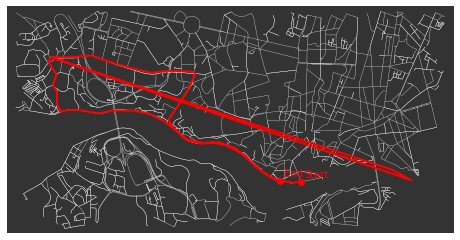

/Users/ming/opt/anaconda3/lib/python3.8/site-packages/osmnx/utils_geo.py:326: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/Users/ming/opt/anaconda3/lib/python3.8/site-packages/osmnx/utils_geo.py:422: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/Users/ming/opt/anaconda3/lib/python3.8/site-packages/osmnx/utils_geo.py:431: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  points_within_geometry = points_within_geometry.append(precise_matches)
/Users/ming/opt/anaconda3/lib/python3.8/site-packages/osmnx/utils_geo.py:431: FutureWarning: The frame.append met

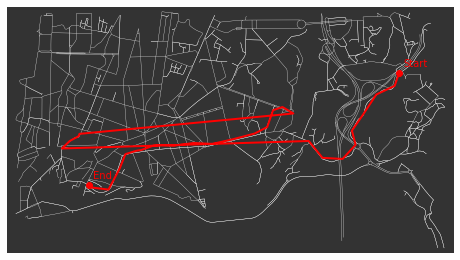

/Users/ming/opt/anaconda3/lib/python3.8/site-packages/osmnx/utils_geo.py:326: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/Users/ming/opt/anaconda3/lib/python3.8/site-packages/osmnx/utils_geo.py:422: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/Users/ming/opt/anaconda3/lib/python3.8/site-packages/osmnx/utils_geo.py:431: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  points_within_geometry = points_within_geometry.append(precise_matches)
/Users/ming/opt/anaconda3/lib/python3.8/site-packages/osmnx/utils_geo.py:431: FutureWarning: The frame.append met

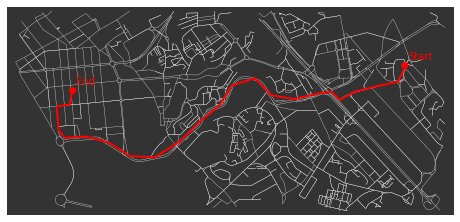

/Users/ming/opt/anaconda3/lib/python3.8/site-packages/osmnx/utils_geo.py:326: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/Users/ming/opt/anaconda3/lib/python3.8/site-packages/osmnx/utils_geo.py:422: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/Users/ming/opt/anaconda3/lib/python3.8/site-packages/osmnx/utils_geo.py:431: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  points_within_geometry = points_within_geometry.append(precise_matches)
/Users/ming/opt/anaconda3/lib/python3.8/site-packages/osmnx/utils_geo.py:431: FutureWarning: The frame.append met

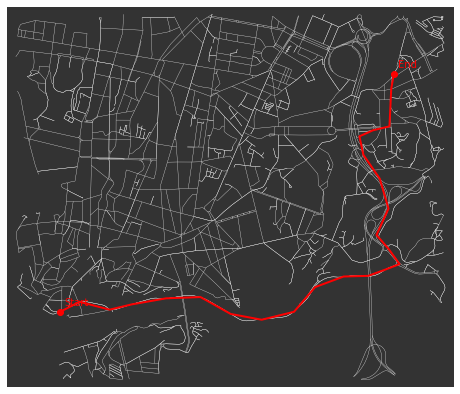

/Users/ming/opt/anaconda3/lib/python3.8/site-packages/osmnx/utils_geo.py:326: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/Users/ming/opt/anaconda3/lib/python3.8/site-packages/osmnx/utils_geo.py:422: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/Users/ming/opt/anaconda3/lib/python3.8/site-packages/osmnx/utils_geo.py:431: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  points_within_geometry = points_within_geometry.append(precise_matches)
/Users/ming/opt/anaconda3/lib/python3.8/site-packages/osmnx/utils_geo.py:431: FutureWarning: The frame.append met

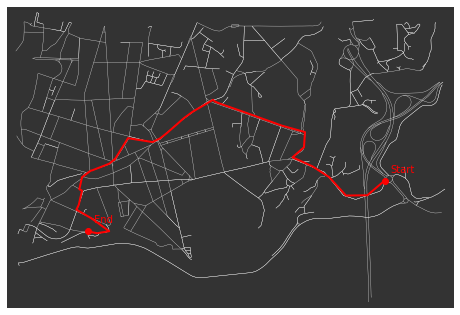

/Users/ming/opt/anaconda3/lib/python3.8/site-packages/osmnx/utils_geo.py:326: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/Users/ming/opt/anaconda3/lib/python3.8/site-packages/osmnx/utils_geo.py:422: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/Users/ming/opt/anaconda3/lib/python3.8/site-packages/osmnx/utils_geo.py:431: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  points_within_geometry = points_within_geometry.append(precise_matches)
/Users/ming/opt/anaconda3/lib/python3.8/site-packages/osmnx/utils_geo.py:431: FutureWarning: The frame.append met

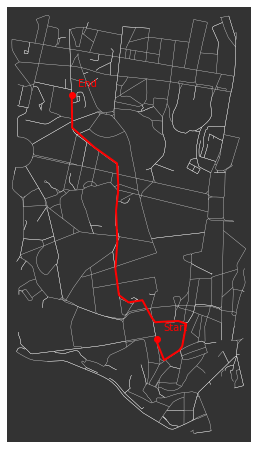

/Users/ming/opt/anaconda3/lib/python3.8/site-packages/osmnx/utils_geo.py:326: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/Users/ming/opt/anaconda3/lib/python3.8/site-packages/osmnx/utils_geo.py:422: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/Users/ming/opt/anaconda3/lib/python3.8/site-packages/osmnx/utils_geo.py:431: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  points_within_geometry = points_within_geometry.append(precise_matches)
/Users/ming/opt/anaconda3/lib/python3.8/site-packages/osmnx/utils_geo.py:431: FutureWarning: The frame.append met

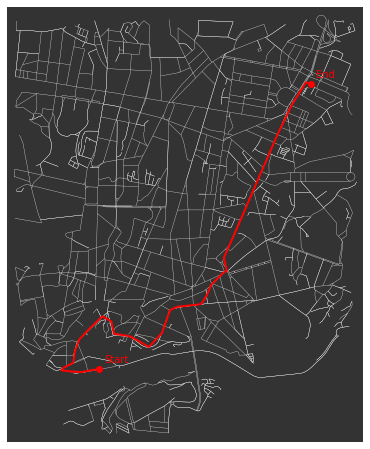

/Users/ming/opt/anaconda3/lib/python3.8/site-packages/osmnx/utils_geo.py:326: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/Users/ming/opt/anaconda3/lib/python3.8/site-packages/osmnx/utils_geo.py:422: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/Users/ming/opt/anaconda3/lib/python3.8/site-packages/osmnx/utils_geo.py:431: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  points_within_geometry = points_within_geometry.append(precise_matches)
/Users/ming/opt/anaconda3/lib/python3.8/site-packages/osmnx/utils_geo.py:431: FutureWarning: The frame.append met

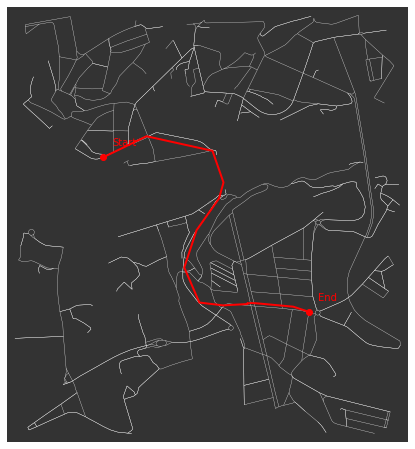

/Users/ming/opt/anaconda3/lib/python3.8/site-packages/osmnx/utils_geo.py:326: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/Users/ming/opt/anaconda3/lib/python3.8/site-packages/osmnx/utils_geo.py:422: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/Users/ming/opt/anaconda3/lib/python3.8/site-packages/osmnx/utils_geo.py:431: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  points_within_geometry = points_within_geometry.append(precise_matches)
/Users/ming/opt/anaconda3/lib/python3.8/site-packages/osmnx/utils_geo.py:431: FutureWarning: The frame.append met

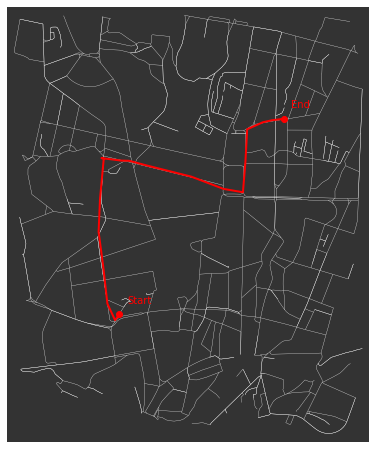

In [4]:
data = pandas.read_csv('/Users/ming/Desktop/Urban computing/final_project/train_1000.csv')
for trip in range(0,11):
    coords = np.array(ast.literal_eval(data.iloc[trip][-1]))
    list_of_x = coords[:, 0]
    list_of_y = coords[:, 1]
    min_x = min(list_of_x - 0.005)
    max_x = max(list_of_x + 0.005)
    min_y = min(list_of_y - 0.005)
    max_y = max(list_of_y + 0.005)
    boundary = [min_x, max_x, min_y, max_y]
    boundary_polygon = Polygon([(min_x,min_y),(max_x,min_y),(max_x,max_y),(min_x,max_y)])
    G = ox.graph_from_polygon(boundary_polygon, network_type='drive')
    #nc = ox.plot.get_node_colors_by_attr(G, attr="y", cmap="viridis")
    fig, ax = ox.plot_graph(
        G,
        show=False,
        close=False,
        bgcolor="#333333",
        edge_color="w",
        edge_linewidth=0.3,
        node_size=0,
    )
    #plt.scatter()
    plt.plot(list_of_x,list_of_y,c="r", linewidth=2)
    plt.plot(list_of_x[0],list_of_y[0],c="r", marker ="o")
    plt.plot(list_of_x[len(list_of_x)-1],list_of_y[len(list_of_y)-1],c="r", marker ="o")
    plt.annotate('Start', (list_of_x[0]+0.0005,list_of_y[0]+0.0005), c='r')
    plt.annotate('End', (list_of_x[len(list_of_x)-1]+0.0005,list_of_y[len(list_of_y)-1]+0.0005), c='r')
    #plt.savefig('unmatched_map_'+str(trip)+'.jpg')
    plt.show()

### Task 3 POST  PROCESS FMM Output 

In [2]:
import csv
import geopandas as gp

#set network name
network_name = "porto_big"
#set to relevant Graph G network files that were saved using FMM author's method
nodes_shp = gp.GeoDataFrame.from_file(network_name + "/nodes.shp")
edges_shp = gp.GeoDataFrame.from_file(network_name + "/edges.shp")


output_file = network_name + '/'+ network_name + "_output.txt"
input_file = network_name + '/trips_time.txt'

with open(output_file) as f:
    lines = f.readlines()
with open(input_file) as f:
    lines_inp = f.readlines()    


trajectories_mapmatched = []
#Identify the list of trajectory that failed map matching and not included in the output
for line in lines[1:]:
    data_list = line.replace("\n", "").split(";")
    if len(data_list[2]) != 0:
        trajectories_mapmatched.append(int(data_list[0]))
#print(trajectories_mapmatched)
#print("Total trajectory matched: ", len(trajectories_mapmatched))

trajectories_failed = []
for i in range(1, 1000):
    if i not in trajectories_mapmatched:
        trajectories_failed.append(i)
#print("Total trajectory failed: ", len(trajectories_failed))
#print(trajectories_failed)

def generate_nodes_edges_from_cpath(cpath):
    nodeOsmidList = []
    roadOsmidList = []
    edgeIndexList = []
    prevRoadOsmid = []
    for edge in cpath:
        road_osmID_str = edges_shp['osmid'][edge]
        if '[' in road_osmID_str:
            roadID = [int(n) for n in road_osmID_str.strip('][').split(', ')]
        else:
            roadID = [int(road_osmID_str)]
        if roadID != prevRoadOsmid:
            roadOsmidList.append(roadID)
        edgeIndexList.append(edge)
        prevNode = int(edges_shp['u'][edge])
        nextNode = int(edges_shp['v'][edge])
        if len(nodeOsmidList) == 0 or nodeOsmidList[len(nodeOsmidList)-1] != prevNode:
            nodeOsmidList.append(prevNode)
        nodeOsmidList.append(nextNode)
        prevRoadOsmid = roadID
    return nodeOsmidList, edgeIndexList, roadOsmidList

nodes_route_list = []
edges_route_list = []
roads_route_list = []
#Convert cpath output to a list of nodes osmID list and edges osmID list 
for line in lines[1:]:
    data_list = line.replace("\n", "").split(";")
    if len(data_list[2]) != 0: #Only work on lines that has valid mapmatched output
        cpath_list_str = data_list[2].split(",")
        cpath_list = [int(n) for n in cpath_list_str]
        nodes_route, edges_route, roads_route = generate_nodes_edges_from_cpath(cpath_list)
        nodes_route_list.append(nodes_route)
        edges_route_list.append(edges_route)
        roads_route_list.append(roads_route)
print("Successfully process nodes, roads and edge indice route")
print("Total nodes/road osmid routes processed", len(nodes_route_list), len(edges_route_list))
print("Total edge indice (map id) routes processed", len(roads_route_list))

wsg84_routes_list = []
#Convert linestring output to a list of WSG84 Points
for line in lines[1:]:
    data_list = line.replace("\n", "").split(";")
    if len(data_list[2]) != 0: #Only work on lines that has valid mapmatched output
        wsg84_points_route = [n.split(" ") for n in data_list[3].replace("LINESTRING", "").strip(")(").split(",")]
        wsg84_points_route = [[float(n[0]), float(n[1])] for n in wsg84_points_route]
        wsg84_routes_list.append(wsg84_points_route)
print("Successfully process wsg84 points route")
print("Total wsg84 routes processed", len(wsg84_routes_list))

#Mark each data instance as a failed of successful FMM mapped trajectory
full_id_order = trajectories_mapmatched + trajectories_failed

raw_gps_points = []
#process raw gps to be saved
inp_data = lines_inp[1:]
for i in inp_data:
    gps_data_list_str = i.split(";")[1]
    gps_data_list_str = gps_data_list_str.replace("LINESTRING", "").strip(")(")
    gps_data_list = gps_data_list_str.split(",")
    gps_data_list = [n.split(" ") for n in gps_data_list]
    gps_data_list = [[float(n[0]), float(n[1])] for n in gps_data_list]
    raw_gps_points.append(gps_data_list)
print("Successfully process raw gps wsg84 points route")
print("Total raw gps wsg84 routes processed", len(raw_gps_points))

#Save the post-processed output under 7 columns csv file, 
#col1: trajectory ID, col2: original raw GPS point list, col3: match_success, col4: fmm-mapped node indice sequence, 
#col5: fmm-mapped edge indice sequence, col6: fmm-mapped WSG84 points sequence 
#header = ['trajectory_id','raw_gps_trajectories', 'match_success','fmm-mapped node indice sequence(osmid)', 'fmm-mapped edge indice sequence(map edge id)',
          #'fmm-mapped road indice sequence(osmid)', 'fmm-mapped WSG84 points sequence', 'fmm-mapped WSG84 points 2nd sequence']
header = ['trajectory_id','raw_gps_trajectories', 'match_success','fmm-mapped node indice sequence(osmid)', 'fmm-mapped edge indice sequence(map edge id)(equivalent to cpath from FMM)',
          'fmm-mapped WSG84 points sequence', 'fmm-mapped WSG84 points 2nd sequence']

with open(network_name + '/postprocessed_output.csv', 'w',  encoding='UTF8', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(header)
    
    for th, i in enumerate(trajectories_mapmatched):
        trajectory_ID = i
        ####gps point load needed
        raw_gps_trajectories = raw_gps_points[trajectory_ID-1]
        matched_success = "True"
        node_indice_sequence = nodes_route_list[th]
        edge_indice_sequence = edges_route_list[th]
        road_indice_sequence = roads_route_list[th]
        wsg84_points_sequence = str(wsg84_routes_list[th])
        if len(wsg84_points_sequence) > 32758:
            print("warning long wsg84 route detected! Splitting data into 2 cells for trajectory ID", i)
            #data = [trajectory_ID, raw_gps_trajectories, matched_success, node_indice_sequence, edge_indice_sequence, 
                    #road_indice_sequence, str(wsg84_points_sequence[0:32758]), str(wsg84_points_sequence[32758:])]
            data = [trajectory_ID, raw_gps_trajectories, matched_success, node_indice_sequence, edge_indice_sequence, 
                    str(wsg84_points_sequence[0:32758]), str(wsg84_points_sequence[32758:])]
        else:
            #data = [trajectory_ID, raw_gps_trajectories, matched_success, node_indice_sequence, edge_indice_sequence, 
                    #road_indice_sequence, str(wsg84_points_sequence), ""]
            data = [trajectory_ID, raw_gps_trajectories, matched_success, node_indice_sequence, edge_indice_sequence, 
                    str(wsg84_points_sequence[0:32758]), str(wsg84_points_sequence[32758:])]
        writer.writerow(data)
            
    for th, i in enumerate(trajectories_failed):
        trajectory_ID = i
        raw_gps_trajectories = raw_gps_points[trajectory_ID-1]
        matched_success = "False"
        data = [i, raw_gps_trajectories, matched_success, "", "", "", "", ""]
        writer.writerow(data)

Successfully process nodes, roads and edge indice route
Total nodes/road osmid routes processed 977 977
Total edge indice (map id) routes processed 977
Successfully process wsg84 points route
Total wsg84 routes processed 977
Successfully process raw gps wsg84 points route
Total raw gps wsg84 routes processed 1000
warning long wsg84 route detected! Splitting data into 2 cells for trajectory ID 506
warning long wsg84 route detected! Splitting data into 2 cells for trajectory ID 282
warning long wsg84 route detected! Splitting data into 2 cells for trajectory ID 836
warning long wsg84 route detected! Splitting data into 2 cells for trajectory ID 335
warning long wsg84 route detected! Splitting data into 2 cells for trajectory ID 650


###  Task 4 Load the saved network 

In [1]:
network_name = "porto_whole1"

#Save graph to use as input for cyang's FMM (Extract Whole Porto)
import osmnx as ox
import time
from shapely.geometry import Polygon
import os
import numpy as np
%matplotlib inline




#### Visualization codes for Task 4 (Input: A set of WSG84 points or cpath output Edges from FMM) (Output: Visualization of the points on Graph G)

In [ ]:
#Alternative visualization method, based on edge cpath data provided by FMM 
#(Less Prefered), not used for report presentation
import matplotlib.pyplot as plt 

output_cpath = [5377,10376,10383,10378,1953,5463,265,5425,5418,5477,5423,5450,5437,5452,5427,6778,6784,6790,6786,9101,9102,5473,5453,5480,10955,4108,10764,4978,4112,2740,6676,6664,4131]
#op = "-8.6186233 41.141456,-8.6183463 41.14133,-8.6182629 41.141292,-8.6174342 41.140917,-8.6182629 41.141292,-8.6183463 41.14133,-8.6187144 41.141497,-8.6188491 41.141582,-8.6198235 41.142218,-8.6200853 41.142389,-8.6202318 41.14249,-8.6203556 41.142575,-8.6209478 41.143157,-8.6212837 41.143398,-8.6213339 41.143434,-8.6216294 41.143598,-8.6216904 41.143624,-8.6220438 41.143771,-8.6225335 41.143949,-8.6231598 41.144138,-8.6235745 41.144265,-8.6243174 41.144494,-8.6247666 41.144632,-8.6250934 41.144735,-8.6254106 41.144793,-8.6266799 41.14476,-8.6267551 41.144759,-8.6268987 41.144728,-8.627037 41.144713,-8.6271975 41.1447,-8.6273413 41.144688,-8.6274999 41.144678,-8.6276791 41.14467,-8.6278804 41.144665,-8.6280428 41.144668,-8.6282135 41.144678,-8.6284404 41.144699,-8.6286688 41.144731,-8.628864 41.144764,-8.6290926 41.144817,-8.6292898 41.144868,-8.6294324 41.144912,-8.6295694 41.144961,-8.629633 41.144985,-8.6297382 41.145024,-8.6299469 41.14512,-8.6301362 41.145216,-8.6303271 41.145324,-8.6307201 41.145592,-8.6307923 41.145641,-8.6314509 41.146137,-8.6315556 41.146204,-8.6316434 41.14626,-8.6318066 41.146363,-8.6326775 41.146843,-8.6328764 41.146954,-8.6327796 41.147062,-8.6327668 41.147077,-8.6327023 41.147151,-8.6326805 41.147177,-8.631553 41.148453,-8.6314991 41.148514,-8.6310069 41.149082,-8.6308723 41.149237,-8.6307611 41.149366,-8.6302954 41.149903,-8.6299508 41.150301,-8.6295157 41.150808,-8.6294233 41.150916,-8.6293113 41.151044,-8.6291323 41.151246,-8.6290736 41.151312,-8.6289862 41.151477,-8.6289736 41.15158,-8.6287691 41.152377,-8.628743 41.152478,-8.6289655 41.152491,-8.6296472 41.152529,-8.6301016 41.152554,-8.6304904 41.152576,-8.6306176 41.152584,-8.6308068 41.152592,-8.6309917 41.152601,-8.6313575 41.152617,-8.6314821 41.15268,-8.6321685 41.15273,-8.6322295 41.152796,-8.6322941 41.152875,-8.6322538 41.15327,-8.6321804 41.153466,-8.6322 41.153604,-8.6321425 41.153694,-8.6320578 41.153797,-8.6319742 41.153879,-8.6318622 41.153974,-8.6318156 41.154007,-8.6317376 41.154068,-8.6313664 41.15433,-8.6310274 41.154568,-8.6308755 41.154531,-8.6307169 41.154492,-8.6307169 41.154492"
op = "-8.63985919436 41.1597515041,-8.6400962 41.1597903,-8.6403509 41.1598321,-8.6405121 41.1598585,-8.6406128 41.1598772,-8.6407255 41.1598951,-8.6407743 41.159903,-8.6409664 41.1599348,-8.6413494 41.1599974,-8.6415073 41.1600235,-8.6416642 41.160048,-8.6418184 41.1600736,-8.641946 41.1600947,-8.6421995 41.160136,-8.6422251 41.1601402,-8.6422821 41.1601499,-8.6425809 41.160201,-8.6426613 41.1602147,-8.6431978 41.1603064,-8.6432898 41.1603218,-8.6433337 41.16033,-8.6437511 41.1604013,-8.6438719 41.1604267,-8.6440381 41.1604654,-8.6441009 41.1604761,-8.6442164 41.1604957,-8.6443184 41.160514,-8.6446539 41.1605742,-8.6447052 41.160584,-8.6448621 41.1606102,-8.6463547 41.1608595,-8.6465544 41.1608924,-8.6477016 41.1610898,-8.6488519 41.1612881,-8.6497412 41.161434,-8.6497816 41.1614398,-8.6501473 41.161503,-8.6502051 41.1615124,-8.6505806 41.1615727,-8.6508766 41.1616294,-8.6510419 41.1616568,-8.6512071 41.1616841,-8.651368 41.1617116,-8.6515596 41.161745,-8.6521101 41.1618428,-8.6522504 41.1618662,-8.6523146 41.1618769,-8.6524869 41.1619056,-8.6526275 41.1619263,-8.6529133 41.1619683,-8.6531355 41.1620035,-8.653766 41.1621082,-8.6538432 41.1621209,-8.6541322 41.162168,-8.6543756 41.162208,-8.6544106 41.162214,-8.6545961 41.1622457,-8.654633 41.162252,-8.6548428 41.1622848,-8.654864 41.1622884,-8.6550093 41.1623133,-8.6551324 41.1623343,-8.6552938 41.1623619,-8.6553489 41.162372,-8.6554041 41.1623821,-8.6557822 41.1624507,-8.6559358 41.1624788,-8.6564631 41.1625694,-8.6566833 41.1626016,-8.6569529 41.162641,-8.6571064 41.1626609,-8.6571879 41.1626742,-8.6573414 41.1626999,-8.6573686 41.1627044,-8.6588565 41.162951,-8.6595502 41.163066,-8.6595823 41.1630712,-8.6598334 41.1631126,-8.6600137 41.1631416,-8.6604048 41.1632086,-8.6604686 41.1632195,-8.6608002 41.1632763,-8.6611031 41.1633282,-8.6611288 41.1633326,-8.6611983 41.1633445,-8.6618323 41.1634531,-8.6621785 41.1635124,-8.6622029 41.1635164,-8.6622347 41.163522,-8.6623938 41.1635486,-8.6627165 41.1636013,-8.6629592 41.1636412,-8.6631404 41.1636742,-8.6634949 41.1637339,-8.6636743 41.1637641,-8.663964 41.1638128,-8.6640147 41.1638213,-8.6643094 41.1638709,-8.6643864 41.1638838,-8.6644792 41.1638995,-8.6645067 41.1639041,-8.6646635 41.1639305,-8.6648192 41.1639566,-8.6648887 41.1639683,-8.6650445 41.1639945,-8.6654797 41.1640677,-8.6657169 41.1641076,-8.665756 41.1641142,-8.6660651 41.1641661,-8.6661082 41.1641734,-8.6665689 41.1642509,-8.6666387 41.1642626,-8.666918 41.1643096,-8.6669895 41.1643216,-8.6671209 41.164344,-8.667201 41.1643572,-8.6674216 41.1643942,-8.6675735 41.1644198,-8.6676683 41.1644357,-8.6678199 41.1644612,-8.6682226 41.1645289,-8.6682651 41.1645361,-8.668518 41.1645786,-8.6688218 41.1646296,-8.6688955 41.164642,-8.6689564 41.1646523,-8.6690153 41.1646622,-8.669115 41.164679,-8.6692925 41.1647087,-8.6704111 41.1648969,-8.6705094 41.1649134,-8.6706651 41.1649396,-8.6707041 41.1649462,-8.6710284 41.1650007,-8.6709117 41.1650601,-8.6708851 41.1650829,-8.6708662 41.1651158,-8.6708502 41.1651526,-8.6708406 41.1652479,-8.6708449 41.165423,-8.6708533 41.1655837,-8.6708611 41.165737,-8.6708663 41.1658119,-8.6708667 41.1658178,-8.6708764 41.1659577,-8.6708781 41.1659864,-8.6708826 41.1661029,-8.6708892 41.1661938,-8.670891 41.1662296,-8.6708977 41.1663589,-8.6708991 41.1663865,-8.6709036 41.1664747,-8.6709091 41.1665828,-8.67091 41.1665995,-8.6709115 41.1666281,-8.6709095 41.1668615,-8.6708949 41.166914,-8.6708051 41.1670494,-8.670752 41.1671171,-8.6707219 41.1671506,-8.6705902 41.1672935,-8.670559 41.167326,-8.670522 41.1673646,-8.6705003 41.1673872,-8.6703822 41.167458,-8.6703525 41.1674757,-8.6701588 41.167592,-8.6701322 41.1676079,-8.6699397 41.1677235,-8.6699155 41.167738,-8.6697206 41.167855,-8.6695481 41.1679586,-8.6695063 41.167985,-8.6694878 41.1679966,-8.6694263 41.1680353,-8.6693877 41.1680597,-8.6692577 41.1681416,-8.6692185 41.1681663,-8.6689348 41.1683689,-8.6687566 41.1684962,-8.6687318 41.1685139,-8.6685319 41.1686567,-8.6684127 41.1687406,-8.6683402 41.1687933,-8.6683251 41.1688031,-8.6683052 41.1688187,-8.6682569 41.1688538,-8.6682108 41.1688873,-8.6681724 41.1689152,-8.668145 41.1689351,-8.6681318 41.1689447,-8.6680988 41.1689687,-8.6680842 41.1689793,-8.6680619 41.1689954,-8.6680414 41.1690103,-8.6680318 41.1690173,-8.6680119 41.1690317,-8.6679804 41.1690546,-8.6677063 41.1692538,-8.6676252 41.1693127,-8.6674488 41.1694319,-8.6673004 41.1695398,-8.6670731 41.1697108,-8.6669487 41.1697954,-8.6663432 41.1702352,-8.6661691 41.1703722,-8.666138 41.1703932,-8.6660889 41.1704311,-8.6660691 41.1704464,-8.6660034 41.1704971,-8.6657486 41.170679,-8.66574668502 41.1706803667"
sample_output_list = op.split(",")
latList = []
longList = []
G = ox.load_graphml(filepath = './' + network_name + '/saved_osmnx_graph')

#calculate the min max points so we know where to focus and zoom into relevant space, 
#essential to ensure optimal visual 
minX, maxX, minY, maxY = 180, -180, 90, -90
for pt in sample_output_list:
    pt_list = pt.split(" ")
    long = float(pt_list[0])
    lat = float(pt_list[1])
    latList.append(lat)
    longList.append(long)
    if minY > lat:
        minY = lat
    if maxY < lat:
        maxY = lat
    if minX > long:
        minX = long
    if maxX < long:
        maxX = long

#Look at the nodes
import geopandas as gp

#set to relevant Graph G network files that were saved using FMM author's method
nodes_shp = gp.GeoDataFrame.from_file(network_name + "/nodes.shp")
edges_shp = gp.GeoDataFrame.from_file(network_name + "/edges.shp")
#point_of_int = str(node_shp['geometry'][1])
#pt_e = point_of_int[7:len(point_of_int)-1]
nodeList = []
edgeList = []
for edge in output_cpath:
    edge_osmID_str = edges_shp['osmid'][edge]
    if '[' in edge_osmID_str:
        edgeID = [int(n) for n in edge_osmID_str.strip('][').split(', ')]
    else:
        edgeID = [int(edge_osmID_str)] 
    edgeList.append(edgeID)
    prevNode = int(edges_shp['u'][edge])
    nextNode = int(edges_shp['v'][edge])
    if len(nodeList) == 0 or nodeList[len(nodeList)-1] != prevNode:
        nodeList.append(prevNode)
    nodeList.append(nextNode)
print("complete preprocess: traversed node osmid list")
print(nodeList)
print("complete preprocess: traversed edge osmid list")
print(edgeList)

#Visualize all the edges traversed 

fig, ax = ox.plot_graph_route(G, nodeList, route_linewidth=6, route_color = "yellow", node_size=100, bgcolor='k', 
                              show=False, close=False,node_alpha=0.5,edge_alpha=1.0)
plt.xlim([minX-0.0033,  maxX+0.0033]) # boundary is 0.0033 * 111 km = 0.3663km beyond trajectory points
plt.ylim([minY-0.0033, maxY+0.0033])
plt.show()

Final Lats and Long List processed finished


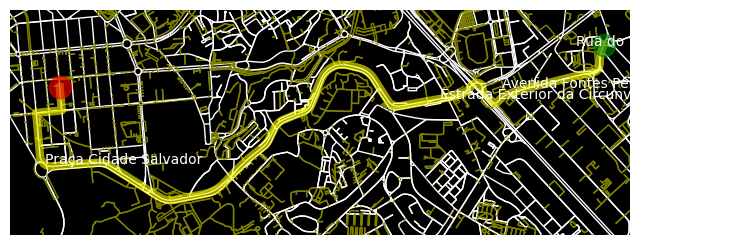

In [419]:
#Visualize Map Matching output using the linestring produced (Recommended) used for final report
#https://stackoverflow.com/questions/60886350/street-names-in-osmnx-network-maps
import matplotlib.pyplot as plt 
import geopandas as gp

G = ox.load_graphml(filepath = './' + network_name + '/saved_osmnx_graph')
#not optimal method
def check_if_annotate_points_valid(point, text):
    x = point[0]
    y = point[1]
    textlen = len(text)
    minX_req = textlen * 0.00030 - 0.0012
    if (maxX - x < minX_req): #shift to left if too right
        correction_factor = textlen * 0.00030 - (maxX - x) - 0.0012
        x = x - correction_factor
    return (x, y)


#Set below 2 to visualize the WSG84 points trajectory from postprocessed_output.csv


#set as fmm-mapped edge indice sequence(map edge id) in the csv
output_cpath = [65337, 65335, 56418, 65340, 5814, 5817, 5818, 40103, 60175, 5821, 758, 751, 68685, 733, 734, 736, 64563, 729, 629, 726, 723, 68858, 13387, 69927, 56494, 13364, 13368, 53310, 631, 69088, 56959, 3843, 56927, 13452, 3836, 3832, 54333, 50336, 54336, 24736, 64573, 24738, 711, 69167, 712, 719, 3874, 61227]
#set as fmm-mapped WSG84 points sequence in the csv file
data_instance = [[-8.6457599, 41.1805278], [-8.645788, 41.1804752], [-8.6458667, 41.1803135], [-8.6459426, 41.1801391], [-8.6459817, 41.1800494], [-8.6460045, 41.1799952], [-8.6460215, 41.1799367], [-8.6460378, 41.1798333], [-8.6460468, 41.179776], [-8.6460652, 41.1796123], [-8.6460704, 41.1794191], [-8.6460962, 41.179322], [-8.646116, 41.1792682], [-8.6461386, 41.1792158], [-8.6461633, 41.179174], [-8.6461889, 41.1791378], [-8.6462308, 41.1790852], [-8.6462625, 41.1790527], [-8.6462971, 41.179028], [-8.6463337, 41.1790078], [-8.6463939, 41.1789837], [-8.6464749, 41.1789593], [-8.646542, 41.1789403], [-8.6465892, 41.1789291], [-8.6467178, 41.1789054], [-8.6469222, 41.1788762], [-8.6470478, 41.178858], [-8.6471733, 41.1788364], [-8.647289, 41.1788244], [-8.6474175, 41.1788081], [-8.6483279, 41.1786394], [-8.6487706, 41.1785574], [-8.6490896, 41.178495], [-8.6497635, 41.1783632], [-8.649904, 41.1783358], [-8.6500118, 41.1783147], [-8.6508998, 41.178155], [-8.65102, 41.178131], [-8.6511943, 41.1780963], [-8.6517575, 41.1779841], [-8.6518195, 41.1779718], [-8.6522026, 41.1778955], [-8.6523446, 41.177873], [-8.6524296, 41.1778563], [-8.6526582, 41.1777999], [-8.6527948, 41.1777597], [-8.6531356, 41.177657], [-8.6533889, 41.1775669], [-8.6534694, 41.1775275], [-8.6535437, 41.1774789], [-8.6537068, 41.1773595], [-8.653874, 41.1772367], [-8.6539809, 41.1771753], [-8.6540178, 41.1771649], [-8.6540546, 41.1771615], [-8.6540936, 41.1771621], [-8.6541347, 41.1771722], [-8.6542056, 41.17718], [-8.6549195, 41.1777668], [-8.6549642, 41.1778146], [-8.6550611, 41.1779551], [-8.6550531, 41.1779779], [-8.6550442, 41.1780031], [-8.6550412, 41.1780502], [-8.6550496, 41.1780992], [-8.6550703, 41.178153], [-8.655091, 41.1781882], [-8.6551101, 41.1782107], [-8.6551378, 41.1782364], [-8.6551656, 41.1782598], [-8.6552027, 41.1782812], [-8.655249, 41.1783026], [-8.6552994, 41.1783165], [-8.6553764, 41.1783259], [-8.6554612, 41.1783254], [-8.6555409, 41.1783156], [-8.6556005, 41.1783058], [-8.6556905, 41.1782761], [-8.6557828, 41.1782386], [-8.6558772, 41.1781827], [-8.655921, 41.1781474], [-8.6559676, 41.1780895], [-8.6559917, 41.1780386], [-8.6560048, 41.178011], [-8.6561379, 41.1779151], [-8.656206, 41.177875], [-8.6563346, 41.1778207], [-8.6564079, 41.1777933], [-8.6564201, 41.1777887], [-8.6564954, 41.1777635], [-8.6571291, 41.1775647], [-8.6572329, 41.1775444], [-8.6573492, 41.1775266], [-8.6577885, 41.1774721], [-8.6587287, 41.1773484], [-8.6592864, 41.1772731], [-8.6606211, 41.177093], [-8.6606666, 41.1770869], [-8.6607866, 41.1770666], [-8.6613013, 41.1769932], [-8.6614455, 41.1769837], [-8.6615784, 41.1769883], [-8.661612, 41.1769933], [-8.6617057, 41.1770074], [-8.6618062, 41.1770287], [-8.6618943, 41.1770583], [-8.6619487, 41.1770812], [-8.6620234, 41.1771175], [-8.6620982, 41.177162], [-8.6621765, 41.1772223], [-8.6622457, 41.1772945], [-8.6626918, 41.1778186], [-8.6627326, 41.1778666], [-8.6629076, 41.1780782], [-8.6629363, 41.1781111], [-8.6633802, 41.1786187], [-8.663455, 41.1786967], [-8.6635949, 41.178815], [-8.6637725, 41.1789299], [-8.6639681, 41.1790314], [-8.6641889, 41.179114], [-8.664433, 41.1791803], [-8.66483, 41.1792576], [-8.6652572, 41.179335], [-8.6654577, 41.1793632], [-8.6656729, 41.1793746], [-8.6658958, 41.1793719], [-8.6661346, 41.1793495], [-8.6663272, 41.1793037], [-8.6663815, 41.1792835], [-8.666556, 41.1792188], [-8.6667517, 41.1791255], [-8.6668989, 41.1790346], [-8.6670475, 41.1789106], [-8.6671537, 41.1788087], [-8.6672268, 41.1787241], [-8.6672967, 41.1786199], [-8.6673804, 41.1784844], [-8.6677937, 41.1777342], [-8.6681544, 41.1770797], [-8.6682161, 41.1769886], [-8.6682804, 41.1769218], [-8.6683575, 41.1768531], [-8.6684581, 41.1767846], [-8.6685542, 41.1767311], [-8.6686502, 41.176689], [-8.6688847, 41.1766157], [-8.6692907, 41.1764989], [-8.6701559, 41.1762389], [-8.6703403, 41.176177], [-8.6705171, 41.176092], [-8.6707111, 41.1759595], [-8.670747, 41.1759315], [-8.6708931, 41.1757606], [-8.6712866, 41.1751617], [-8.6714309, 41.1749574], [-8.6715329, 41.1748481], [-8.6716617, 41.1747387], [-8.6718657, 41.1746048], [-8.6728001, 41.1740409], [-8.6731666, 41.1737963], [-8.6735889, 41.1734848], [-8.6737186, 41.1733851], [-8.6741612, 41.1730446], [-8.6741712, 41.1730368], [-8.6743126, 41.1729273], [-8.6744036, 41.1728569], [-8.6746729, 41.1726483], [-8.6750157, 41.1724009], [-8.6751369, 41.1723306], [-8.6752847, 41.1722516], [-8.6754622, 41.1721696], [-8.6756684, 41.1720947], [-8.6758382, 41.1720387], [-8.6760185, 41.1719881], [-8.6762209, 41.1719469], [-8.6764994, 41.171906], [-8.6773977, 41.1717743], [-8.6778879, 41.1717025], [-8.6786557, 41.1715868], [-8.6788299, 41.1715807], [-8.6790176, 41.1715818], [-8.6791299, 41.1715919], [-8.6793201, 41.1716257], [-8.6795008, 41.1716754], [-8.6796451, 41.1717308], [-8.6800848, 41.1719349], [-8.680367, 41.1720662], [-8.6804089, 41.1720857], [-8.6808227, 41.1722857], [-8.6809257, 41.1723355], [-8.6810624, 41.1724038], [-8.6812804, 41.1725061], [-8.6825815, 41.1731265], [-8.6831561, 41.173405], [-8.6835598, 41.1735921], [-8.6837295, 41.1736548], [-8.6838883, 41.1736972], [-8.6840605, 41.1737268], [-8.6842851, 41.1737406], [-8.6845232, 41.1737341], [-8.6845707, 41.1737315], [-8.6845762, 41.1737312], [-8.6848695, 41.1737148], [-8.6851057, 41.1737004], [-8.6851768, 41.1736961], [-8.6861261, 41.1736449], [-8.6867817, 41.1735974], [-8.6867896, 41.1735968], [-8.6878176, 41.1735312], [-8.6879427, 41.1735251], [-8.6880455, 41.1735254], [-8.6881439, 41.1735377], [-8.6882331, 41.1735553], [-8.688297, 41.173575], [-8.6884308, 41.1736164], [-8.6884888, 41.1736579], [-8.6885503, 41.1736915], [-8.688556, 41.1737314], [-8.6886089, 41.173775], [-8.6886524, 41.1738033], [-8.6887138, 41.1738495], [-8.6887505, 41.1738854], [-8.6887841, 41.1739312], [-8.68881, 41.1739971], [-8.6888179, 41.1740417], [-8.6889019, 41.1747167], [-8.6889211, 41.1748819], [-8.6889548, 41.1751691], [-8.6890163, 41.1756947], [-8.6890334, 41.1758415], [-8.6890398, 41.1758959], [-8.6890928, 41.1763492], [-8.6891215, 41.1765654], [-8.6891266, 41.1765964], [-8.6888247, 41.1766248], [-8.6885702, 41.1766432], [-8.6882868, 41.1766636], [-8.6881458, 41.1766738], [-8.68803, 41.1766836], [-8.6873167, 41.1767337], [-8.6871669, 41.1767445], [-8.6871814, 41.1768565], [-8.6871962, 41.1769706], [-8.6872084, 41.1770711], [-8.6872124, 41.177104], [-8.6872368, 41.1773067], [-8.6872491, 41.1774091], [-8.68732982988, 41.178079555]]


#extract edge and node high level information data for visual annotation and decoration work
nodes_shp = gp.GeoDataFrame.from_file(network_name + "/nodes.shp")
edges_shp = gp.GeoDataFrame.from_file(network_name + "/edges.shp")
edges_sequence = [edges_shp[x:x+1] for x in output_cpath]
nodes_sequence = [int(edge['u']) for edge in edges_sequence]



latList = []
longList = []
minX, maxX, minY, maxY = 180, -180, 90, -90
#process the trajectory data
for pt in data_instance:
    long, lat = pt[0], pt[1]
    latList.append(lat)
    longList.append(long)
    if minX > long:
        minX = long
    if maxX < long:
        maxX = long
    if minY > lat:
        minY = lat
    if maxY < lat:
        maxY = lat

print("Final Lats and Long List processed finished")

#Comment the line below if prefer simpler and concise graph used for FMM matching
road_types = []
for x in list(G.edges(data=True)):
    if x[2]['highway'] not in road_types:
        road_types.append(x[2]['highway'])      
G2 = ox.graph.graph_from_bbox(maxY + 0.003, minY - 0.003, minX - 0.003, maxX + 0.003, network_type='all')
ec = ['white' if z['highway'] in road_types else 'olive' for _, _, z in G2.edges(data=True)]
#End#


fig, ax = ox.plot_graph(G2, show=False, close=False,node_alpha=0.5,edge_alpha=1.0, 
                        bgcolor='black',node_color='white', node_size=0, edge_color=ec)
#fig, ax = ox.plot_graph(G, show=False, close=False,node_alpha=0.5,edge_alpha=1.0, 
#                        bgcolor='black',node_color='white', node_size=0)
plt.xlim([minX - 0.002,  maxX + 0.002])
plt.ylim([minY - 0.002, maxY + 0.002])

#plot trajectory lines with attribute
plt.plot(longList,latList,"yellow", alpha=0.6, linewidth=6)
#mark start point
plt.plot(longList[0], latList[0], c="green", alpha=0.6, markersize=16, marker ="o")
#mark end point
plt.plot(longList[len(longList)-1], latList[len(latList)-1], c="red", alpha=0.6, markersize=16, marker ="o")


#Annotation code
last_edge_id = -1
last_text = ""
for i, edge in enumerate(edges_sequence):
    c = edge['geometry'].iloc[0].interpolate(0.5, normalized = True)
    if last_edge_id == -1 or i == len(edges_sequence): #always annotate start and end points
        harv_dist = 0
        text = str(edge['name'].iloc[0])
        annotate_point = check_if_annotate_points_valid((c.x, c.y), text)
        ax.annotate(text, (annotate_point[0], annotate_point[1]), c='w')
        last_text = text 
        last_edge_id = i
        #print("first update")
    else:
        last_c = edges_sequence[last_edge_id]['geometry'].iloc[0].interpolate(0.5, normalized = True)
        harv_dist = ox.distance.great_circle_vec(c.x, c.y, last_c.x, last_c.y)
        #print("harv_dist", harv_dist)
        text = str(edge['name'].iloc[0])
        
        if harv_dist >= annotation_interval and last_text != text: #annotate point with text is diff from last annotation
            annotate_point = check_if_annotate_points_valid((c.x, c.y), text)
            ax.annotate(text, (annotate_point[0], annotate_point[1]), c='w')
            last_text = text
            last_edge_id = i
        elif harv_dist >= 5 * annotation_interval and last_text == text: #if annotation is same as previous annotation, repeat lesser
            annotate_point = check_if_annotate_points_valid((c.x, c.y), text)
            ax.annotate(text, (annotate_point[0], annotate_point[1]), c='w')
            last_text = text
            last_edge_id = i
    
plt.show()

### Analysis of Map matching result Python code (Task 5)

In [ ]:
#Process the post-processed fmm output to build a table describing how many times each edges were traverse
#Task 5(1)
#print and visualize the top 5 road segment (edges) that were traversed by the 1000 trajectories (Task 5(1))

#use harveine distance NOT euclidean distance
#Task 5(2)
#An algorithm to associate each of the trajectory GPS points to a relevant edge, 

#for each trajectory data:

#for each GPS point in trajectory data:
#compares if the GPS point is nearest to the active edge 'destination v' field or the incoming edge 'origin u' field. 
#if GPS point is near to the active edge destination, assign +1 point to the active edge and move to analyze the next GPS point, 
#else if GPS point is near to the incoming edge origin, assign +1 point to the incoming edge, 
#then update active edge as incoming edge. Move on to the next GPS point. 
#:until all the GPS point in trajectory are assigned to an edge traversed.

#for each edge traversed in this trajectory data:
#update the sum total time taken to traversed all the relevant edge for all trajectory point 
#(needed to find average time traveled for each edge later)

#:until all trajectory data completed the above

#for each edge traversed in the 1000 trajectories.
#average_duration = divide the sum total time traversed by all 1000 trajectories by the number of times each edges were traversed
#this average duration is in GPS points per traverse attempt
#For each GPS point assiocated to the edge, 15seconds were spent. 
#Total approximate time can be calculated as 15s * no of GPS point allocated to this edge 

#Print and visualize the top 5 edges that were assigned the most GPS point per traverse attempt. (Task 5 (2))

#For each GPS point assigned means that the edge took 15s


In [5]:
import pandas as pd
import numpy as np
import osmnx as ox
from shapely.geometry import Polygon
import ast
import matplotlib.pyplot as plt

edge_time_freq = pd.read_csv('./data/edge_time_freq.csv')
most_traversed = edge_time_freq.sort_values(by='traverse frequency', ascending=False)
longest_travel_time = edge_time_freq.sort_values(by='avg traverse time(s)', ascending=False)

def lighten_color(color, amount=0.5):
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

[]


<ipython-input-6-d2525faf5788>:5: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  for entry in most_traversed['points sequence'][:5]:
/Users/ming/opt/anaconda3/lib/python3.8/site-packages/osmnx/utils_geo.py:326: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/Users/ming/opt/anaconda3/lib/python3.8/site-packages/osmnx/utils_geo.py:422: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/Users/m

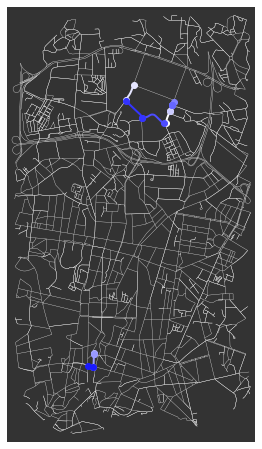

In [6]:
### Visalization of most traversed edges
list_of_x = []
list_of_y = []
print(list_of_x)
for entry in most_traversed['points sequence'][:5]:
    coords = np.array(ast.literal_eval(entry))
    list_of_x.append(coords[:, 0])
    list_of_y.append(coords[:, 1])
list_of_x = np.concatenate(list_of_x, axis=0)
list_of_y = np.concatenate(list_of_y, axis=0)

min_x = np.min(list_of_x) - 0.012
max_x = np.max(list_of_x) + 0.012
min_y = np.min(list_of_y) - 0.008
max_y = np.max(list_of_y) + 0.008
    
boundary = [min_x, max_x, min_y, max_y]
boundary_polygon = Polygon([(min_x,min_y),(max_x,min_y),(max_x,max_y),(min_x,max_y)])
G = ox.graph_from_polygon(boundary_polygon, network_type='drive')

fig, ax = ox.plot_graph(
    G,
    close=False,
    show=False,
    bgcolor="#333333",
    edge_color="w",
    edge_linewidth=0.3,
    node_size=0,
)
for i, entry in enumerate(most_traversed['points sequence'][:10]):
    coords = np.array(ast.literal_eval(entry))
    list_of_x = coords[:, 0]
    list_of_y = coords[:, 1]

    plt.plot(list_of_x,list_of_y,linewidth=2, c=lighten_color('b', i*0.1))
    plt.plot(list_of_x[0],list_of_y[0],marker ="o", c=lighten_color('b', i*0.1))
    plt.plot(list_of_x[len(list_of_x)-1],list_of_y[len(list_of_y)-1],c=lighten_color('b', i*0.1), marker ="o")
plt.show()

<ipython-input-7-e38582a9501f>:6: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  for entry in longest_travel_time['points sequence'][:10]:
/Users/ming/opt/anaconda3/lib/python3.8/site-packages/osmnx/utils_geo.py:326: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:


[]


/Users/ming/opt/anaconda3/lib/python3.8/site-packages/osmnx/utils_geo.py:422: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/Users/ming/opt/anaconda3/lib/python3.8/site-packages/osmnx/utils_geo.py:431: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  points_within_geometry = points_within_geometry.append(precise_matches)
/Users/ming/opt/anaconda3/lib/python3.8/site-packages/osmnx/utils_geo.py:431: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  points_within_geometry = points_within_geometry.append(precise_matches)
/Users/ming/opt/anaconda3/lib/python3.8/site-packages/osmnx/utils_geo.py:431: FutureWarning: The frame.append method is deprecated

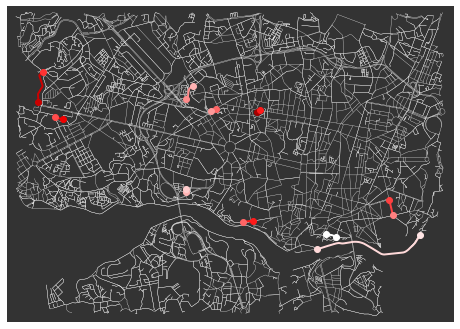

In [7]:
## Visualization of edges which has the largest traverse time

list_of_x = []
list_of_y = []
print(list_of_x)
for entry in longest_travel_time['points sequence'][:10]:
    coords = np.array(ast.literal_eval(entry))
    list_of_x.append(coords[:, 0])
    list_of_y.append(coords[:, 1])
list_of_x = np.concatenate(list_of_x, axis=0)
list_of_y = np.concatenate(list_of_y, axis=0)

min_x = np.min(list_of_x) - 0.005
max_x = np.max(list_of_x) + 0.005
min_y = np.min(list_of_y) - 0.01
max_y = np.max(list_of_y) + 0.01
    
boundary = [min_x, max_x, min_y, max_y]
boundary_polygon = Polygon([(min_x,min_y),(max_x,min_y),(max_x,max_y),(min_x,max_y)])
G = ox.graph_from_polygon(boundary_polygon, network_type='drive')

fig, ax = ox.plot_graph(
    G,
    #close=False,
    show=False,
    bgcolor="#333333",
    edge_color="w",
    edge_linewidth=0.3,
    node_size=0,
)

for i, entry in enumerate(longest_travel_time['points sequence'][:10]):
    coords = np.array(ast.literal_eval(entry))
    list_of_x = coords[:, 0]
    list_of_y = coords[:, 1]
    #plt.scatter()

    plt.plot(list_of_x,list_of_y,linewidth=2, c=lighten_color('r', i*0.15))
    plt.plot(list_of_x[0],list_of_y[0],marker ="o", c=lighten_color('r', i*0.15))
    plt.plot(list_of_x[len(list_of_x)-1],list_of_y[len(list_of_y)-1],c=lighten_color('r', i*0.1), marker ="o")
    
plt.show()

In [ ]:
import geopandas as gp
print("Show some sample edges from the graph")
edge_dataframe = gp.GeoDataFrame.from_file( "porto_city/edges.shp")

print("Total edges in the graph: ", len(edge_dataframe))
edge_dataframe[0:10]

In [425]:
import geopandas as gp
import osmnx as ox
import numpy as np
import time
import csv
import os

import matplotlib.pyplot as plt

from tqdm import tqdm
from shapely.geometry import Polygon
from math import radians, cos, sin, asin, sqrt

In [433]:
edge_dataframe = gp.GeoDataFrame.from_file('porto_whole1/edges.shp')
#print('Total edges in the graph:' , len(edge_dataframe))
#edge_dataframe.head()

nodes_dataframe = gp.GeoDataFrame.from_file('porto_whole1/nodes.shp')
#print('Total nodes in the graph: ', len(nodes_dataframe))
#nodes_dataframe.head()

In [452]:
def get_edge_frequency():
    csv_data = open('porto_whole1/postprocessed_output.csv', 'r')
    dict_reader = csv.DictReader(csv_data)
    
    edge_frequnce = {}
    
    for item in dict_reader:
        if item['match_success'] == 'FALSE':
            break
        edge_index = eval(item['fmm-mapped edge indice sequence(map edge id)(equivalent to cpath from FMM)'])
        for i in edge_index:
            if i in edge_frequnce.keys():
                edge_frequnce[i] = edge_frequnce[i] + 1
            else:
                edge_frequnce[i] = 1
        
    csv_data.close()
    return edge_frequnce

In [455]:
edge_freq = get_edge_frequency()
#print(edge_freq)

In [456]:
class Edge(object):
    def __init__(self, idx, u, v, geometry):
        self.idx = idx
        self.u = u
        self.v = v
        self.geometry = geometry

In [457]:
def get_edge_from_idx(index):
    edge_data = edge_dataframe.iloc[index]
    u_pos = np.flatnonzero(nodes_dataframe['osmid']==edge_data.u)
    node_u_data = nodes_dataframe.iloc[u_pos]
    v_pos = np.flatnonzero(nodes_dataframe['osmid']==edge_data.v)
    node_v_data = nodes_dataframe.iloc[v_pos]
    
    u = (node_u_data.x.iloc[0], node_u_data.y.iloc[0])
    v = (node_v_data.x.iloc[0], node_v_data.y.iloc[0])
    geo = edge_data.geometry
    
    
    edge = Edge(index, u, v, geo)
    
    return edge

In [458]:
def dict_add_n(dict_to_add, key, n):
    if key in dict_to_add.keys():
        dict_to_add[key] += n
    else:
        dict_to_add[key] = n

In [459]:
def haversine_dist(coord1, coord2):
    lon1, lat1 = coord1[0], coord1[1]
    lon2, lat2 = coord2[0], coord2[1]
    
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles. Determines return value units.
    return c * r

In [466]:
def get_edge_timeslice():
    csv_data = open('porto_whole1/postprocessed_output.csv', 'r')
    dict_reader = csv.DictReader(csv_data)
    
    edge_timeslice_list = []
    edge_timeslice_dict = {}
    
    processing_count = 1
    with tqdm(total=662) as _tqdm:
        for item in dict_reader:
            _tqdm.set_description('processing: {}/{} trajectory'.format(processing_count, 662))
            trajectory_edge_timeslice = {}
            if item['match_success'] == 'FALSE':
                continue
            raw_gps_trajectories = eval(item['raw_gps_trajectories'])
            edge_seq = eval(item['fmm-mapped edge indice sequence(map edge id)(equivalent to cpath from FMM)'])

            g_pointer = 0
            e_pointer = 0


            while g_pointer < len(raw_gps_trajectories):
                edge = get_edge_from_idx(edge_seq[e_pointer])
                gps_coord = raw_gps_trajectories[g_pointer]

                if e_pointer == len(edge_seq) - 1:
                    dict_add_n(trajectory_edge_timeslice, edge.idx, 1)
                    g_pointer += 1
                    continue

                if haversine_dist(gps_coord, edge.u) > haversine_dist(edge.u, edge.v):
                    e_pointer += 1
                    edge = get_edge_from_idx(edge_seq[e_pointer])

                dict_add_n(trajectory_edge_timeslice, edge.idx, 1)
                g_pointer += 1
                
            _tqdm.update(1)
            processing_count += 1
            edge_timeslice_list.append(trajectory_edge_timeslice)
        
    edge_timeslice_dict = compute_edge_timeslice(edge_timeslice_list)
    return edge_timeslice_dict

In [469]:
def compute_edge_timeslice(edge_timeslice_list):
    edge_timeslice_dict = {}
    for i in range(0, len(edge_dataframe)):
        count = 0
        for item in edge_timeslice_list:
            if i in item.keys():
                dict_add_n(edge_timeslice_dict, i, item[i])
                count += 1
        if i in edge_timeslice_dict.keys():
            edge_timeslice_dict[i] = edge_timeslice_dict[i] / count
    
    return edge_timeslice_dict   

In [470]:
edge_timeslice = get_edge_timeslice()

processing: 662/662 trajectory: 100%|███████████████████████████████████████████████▉| 661/662 [01:29<00:00,  7.40it/s]


In [471]:
def write_edge_time_freq(target_file_path, edge_timeslice, edge_frequency):
    target_csv = open(target_file_path, 'w', newline='')
    dict_writer = csv.writer(target_csv)
    
    file_header = ['edge index', 'traverse frequency', 'avg traverse time(s)', 'geometry', 'points sequence']
    dict_writer.writerow(file_header)
    
    for k in edge_frequency.keys():
        row = []
        row.append(k)
        row.append(edge_frequency[k])
        if k in edge_timeslice.keys():
            row.append(edge_timeslice[k] * 15)
        else:
            row.append('')
        geo = edge_dataframe.iloc[k].geometry
        row.append(geo)
        points = []
        for (x, y) in zip(geo.xy[0], geo.xy[1]):
            points.append([x, y])
        row.append(points)
        
        dict_writer.writerow(row)
    
    target_csv.close() 

In [473]:
write_edge_time_freq('data/edge_time_freq.csv', edge_timeslice, edge_freq)

### Task 6 Codes

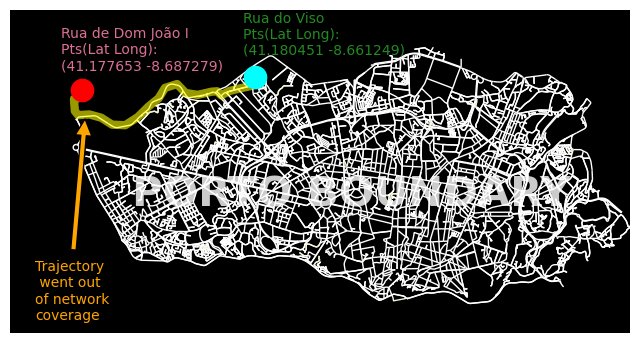

In [416]:
#Generation of Figure X in the report

#After 3 661/1000 success. #plot trajectory ID 3 to demonstrate why cause 1 happen
#sample_failed_1 = [[-8.645994, 41.18049], [-8.645949, 41.180517], [-8.646048, 41.180049], [-8.646804, 41.178888], [-8.649495, 41.178465], [-8.65215, 41.177961], [-8.654049, 41.177196], [-8.655012, 41.177925], [-8.656353, 41.177853], [-8.659647, 41.177277], [-8.662518, 41.177619], [-8.664561, 41.179221], [-8.667432, 41.178537], [-8.668944, 41.176674], [-8.671374, 41.17518], [-8.673894, 41.173308], [-8.676918, 41.171841], [-8.680032, 41.171949], [-8.682615, 41.173191], [-8.685441, 41.173776], [-8.688105, 41.17365], [-8.688879, 41.174379], [-8.689059, 41.17608], [-8.689086, 41.176431], [-8.689059, 41.176593], [-8.687502, 41.176755], [-8.687259, 41.177781], [-8.687259, 41.178078], [-8.687268, 41.178087]]
sample_failed_1 = [[-8.645994, 41.18049], [-8.645949, 41.180517], [-8.646048, 41.180049], [-8.646804, 41.178888], [-8.649495, 41.178465], [-8.65215, 41.177961], [-8.654049, 41.177196], [-8.655012, 41.177925], [-8.656353, 41.177853], [-8.659647, 41.177277], [-8.662518, 41.177619], [-8.664561, 41.179221], [-8.667432, 41.178537], [-8.668944, 41.176674], [-8.671374, 41.17518], [-8.673894, 41.173308], [-8.676918, 41.171841], [-8.680032, 41.171949], [-8.682615, 41.173191], [-8.685441, 41.173776], [-8.688105, 41.17365], [-8.688879, 41.174379], [-8.689059, 41.17608], [-8.689086, 41.176431], [-8.689059, 41.176593], [-8.687502, 41.176755], [-8.687259, 41.177781], [-8.687259, 41.178078], [-8.687268, 41.178087]]

sample_failed_1_edges = [65337, 61227]
#Visualize Map Matching output using the linestring produced (Recommended)
#https://stackoverflow.com/questions/60886350/street-names-in-osmnx-network-maps
import matplotlib.pyplot as plt 
import matplotlib 
import geopandas as gp
network_name = "porto_big"
import osmnx as ox
import time
from shapely.geometry import Polygon
import os
import numpy as np
%matplotlib inline

G = ox.load_graphml(filepath = './' + network_name + '/saved_osmnx_graph')
#not optimal method
def check_if_annotate_points_valid(point, text):
    x = point[0]
    y = point[1]
    textlen = len(text)
    minX_req = textlen * 0.00030 - 0.0012
    if (maxX - x < minX_req): #shift to left if too right
        correction_factor = textlen * 0.00030 - (maxX - x) - 0.0012
        x = x - correction_factor
    return (x, y)

output_cpath = sample_failed_1_edges
data_instance = sample_failed_1

#extract edge and node high level information data for visual annotation and decoration work
nodes_shp = gp.GeoDataFrame.from_file(network_name + "/nodes.shp")
edges_shp = gp.GeoDataFrame.from_file(network_name + "/edges.shp")
edges_sequence = [edges_shp[x:x+1] for x in output_cpath]
nodes_sequence = [int(edge['u']) for edge in edges_sequence]

latList = []
longList = []
minX, maxX, minY, maxY = 180, -180, 90, -90
#process the trajectory data
for pt in data_instance:
    long, lat = pt[0], pt[1]
    latList.append(lat)
    longList.append(long)
    if minX > long:
        minX = long
    if maxX < long:
        maxX = long
    if minY > lat:
        minY = lat
    if maxY < lat:
        maxY = lat

xi = np.array(list(range(int(minX*1e6), int(maxX*1e6), 1))) / 1e6
yi = np.array(list(range(int(minY*1e6), int(maxY*1e6), 1))) / 1e6

#Comment the line below if prefer simpler and concise graph used for FMM matching
road_types = []
for x in list(G.edges(data=True)):
    if x[2]['highway'] not in road_types:
        road_types.append(x[2]['highway'])      
place ="Porto, Portugal"
G2 = ox.graph_from_place(place, network_type='drive')
ec = ['white' if z['highway'] in road_types else 'beige' for _, _, z in G2.edges(data=True)]
#End#
fig, ax = ox.plot_graph(G2, show=False, close=False,node_alpha=0.5,edge_alpha=1.0, 
                        bgcolor='black',node_color='white', node_size=0, edge_color=ec)

plt.xlim([-8.704321,  -8.556760])
plt.ylim([41.134614, 41.192510])
#plot trajectory lines with attribute
plt.plot(longList,latList,"yellow", alpha=0.6, linewidth=6)
#mark start point
plt.plot(longList[0], latList[0], c="cyan", alpha=1.0, markersize=16, marker ="o")
#mark end point
plt.plot(longList[len(longList)-1], latList[len(latList)-1], c="red", alpha=1.0, markersize=16, marker ="o")

#Annotation code
text_list = []
last_text = ""
for i, edge in enumerate(edges_sequence):
    c = edge['geometry'].iloc[0].interpolate(0.5, normalized = True)
    if i == 0 or i == len(edges_sequence)-1: #always annotate start and end points
        harv_dist = 0
        annotate_point = check_if_annotate_points_valid((c.x, c.y), text)
        text = str(edge['name'].iloc[0]) + " \nPts(Lat Long):\n(" + str(round(annotate_point[::-1][0], 6)) + " "+str(round(annotate_point[::-1][1], 6)) +")" 
        if i == 0:
            ax.annotate(text, (annotate_point[0]+0.0125, annotate_point[1]+0.004), c='forestgreen')
        elif i == len(edges_sequence)-1:
            ax.annotate(text, (annotate_point[0]-0.005, annotate_point[1]+0.004), c='palevioletred')
        text_list.append(text)
        last_text = text 
        last_edge_id = i

ax.annotate(text="PORTO BOUNDARY", xy=(-8.675218, 41.157323), weight = 'bold', c='w', size=30, alpha = 0.8)
arrowprops=dict(facecolor='orange', shrink=0.05)
ax.annotate("Trajectory\n went out \nof network\ncoverage", xy=(-8.686300, 41.174300), xytext=(-8.698300, 41.13700), c='orange', arrowprops=arrowprops)
plt.show()

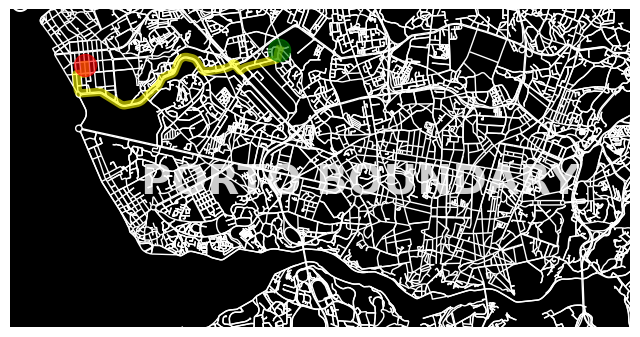

In [417]:
#Generation of Figure X2 in the report

#Plot the corrected trajectoryID 5 after applying Cause 1 Fix
import matplotlib.pyplot as plt 
import geopandas as gp
G = ox.load_graphml(filepath = './' + network_name + '/saved_osmnx_graph')

#set as fmm-mapped WSG84 points sequence in the csv file
data_instance = [[-8.6457599, 41.1805278], [-8.645788, 41.1804752], [-8.6458667, 41.1803135], [-8.6459426, 41.1801391], 
                 [-8.6459817, 41.1800494], [-8.6460045, 41.1799952], [-8.6460215, 41.1799367], [-8.6460378, 41.1798333], 
                 [-8.6460468, 41.179776], [-8.6460652, 41.1796123], [-8.6460704, 41.1794191], [-8.6460962, 41.179322], 
                 [-8.646116, 41.1792682], [-8.6461386, 41.1792158], [-8.6461633, 41.179174], [-8.6461889, 41.1791378], 
                 [-8.6462308, 41.1790852], [-8.6462625, 41.1790527], [-8.6462971, 41.179028], [-8.6463337, 41.1790078], 
                 [-8.6463939, 41.1789837], [-8.6464749, 41.1789593], [-8.646542, 41.1789403], [-8.6465892, 41.1789291], 
                 [-8.6467178, 41.1789054], [-8.6469222, 41.1788762], [-8.6470478, 41.178858], [-8.6471733, 41.1788364], 
                 [-8.647289, 41.1788244], [-8.6474175, 41.1788081], [-8.6483279, 41.1786394], [-8.6487706, 41.1785574], 
                 [-8.6490896, 41.178495], [-8.6497635, 41.1783632], [-8.649904, 41.1783358], [-8.6500118, 41.1783147], 
                 [-8.6508998, 41.178155], [-8.65102, 41.178131], [-8.6511943, 41.1780963], [-8.6517575, 41.1779841], 
                 [-8.6518195, 41.1779718], [-8.6522026, 41.1778955], [-8.6523446, 41.177873], [-8.6524296, 41.1778563], 
                 [-8.6526582, 41.1777999], [-8.6527948, 41.1777597], [-8.6531356, 41.177657], [-8.6533889, 41.1775669], 
                 [-8.6534694, 41.1775275], [-8.6535437, 41.1774789], [-8.6537068, 41.1773595], [-8.653874, 41.1772367], 
                 [-8.6539809, 41.1771753], [-8.6540178, 41.1771649], [-8.6540546, 41.1771615], [-8.6540936, 41.1771621], 
                 [-8.6541347, 41.1771722], [-8.6542056, 41.17718], [-8.6549195, 41.1777668], [-8.6549642, 41.1778146], 
                 [-8.6550611, 41.1779551], [-8.6550531, 41.1779779], [-8.6550442, 41.1780031], [-8.6550412, 41.1780502], 
                 [-8.6550496, 41.1780992], [-8.6550703, 41.178153], [-8.655091, 41.1781882], [-8.6551101, 41.1782107], 
                 [-8.6551378, 41.1782364], [-8.6551656, 41.1782598], [-8.6552027, 41.1782812], [-8.655249, 41.1783026], 
                 [-8.6552994, 41.1783165], [-8.6553764, 41.1783259], [-8.6554612, 41.1783254], [-8.6555409, 41.1783156], 
                 [-8.6556005, 41.1783058], [-8.6556905, 41.1782761], [-8.6557828, 41.1782386], [-8.6558772, 41.1781827], 
                 [-8.655921, 41.1781474], [-8.6559676, 41.1780895], [-8.6559917, 41.1780386], [-8.6560048, 41.178011], 
                 [-8.6561379, 41.1779151], [-8.656206, 41.177875], [-8.6563346, 41.1778207], [-8.6564079, 41.1777933], 
                 [-8.6564201, 41.1777887], [-8.6564954, 41.1777635], [-8.6571291, 41.1775647], [-8.6572329, 41.1775444], 
                 [-8.6573492, 41.1775266], [-8.6577885, 41.1774721], [-8.6587287, 41.1773484], [-8.6592864, 41.1772731], 
                 [-8.6606211, 41.177093], [-8.6606666, 41.1770869], [-8.6607866, 41.1770666], [-8.6613013, 41.1769932], 
                 [-8.6614455, 41.1769837], [-8.6615784, 41.1769883], [-8.661612, 41.1769933], [-8.6617057, 41.1770074], 
                 [-8.6618062, 41.1770287], [-8.6618943, 41.1770583], [-8.6619487, 41.1770812], [-8.6620234, 41.1771175], 
                 [-8.6620982, 41.177162], [-8.6621765, 41.1772223], [-8.6622457, 41.1772945], [-8.6626918, 41.1778186], 
                 [-8.6627326, 41.1778666], [-8.6629076, 41.1780782], [-8.6629363, 41.1781111], [-8.6633802, 41.1786187], 
                 [-8.663455, 41.1786967], [-8.6635949, 41.178815], [-8.6637725, 41.1789299], [-8.6639681, 41.1790314], 
                 [-8.6641889, 41.179114], [-8.664433, 41.1791803], [-8.66483, 41.1792576], [-8.6652572, 41.179335], 
                 [-8.6654577, 41.1793632], [-8.6656729, 41.1793746], [-8.6658958, 41.1793719], [-8.6661346, 41.1793495], 
                 [-8.6663272, 41.1793037], [-8.6663815, 41.1792835], [-8.666556, 41.1792188], [-8.6667517, 41.1791255], 
                 [-8.6668989, 41.1790346], [-8.6670475, 41.1789106], [-8.6671537, 41.1788087], [-8.6672268, 41.1787241], 
                 [-8.6672967, 41.1786199], [-8.6673804, 41.1784844], [-8.6677937, 41.1777342], [-8.6681544, 41.1770797], 
                 [-8.6682161, 41.1769886], [-8.6682804, 41.1769218], [-8.6683575, 41.1768531], [-8.6684581, 41.1767846], 
                 [-8.6685542, 41.1767311], [-8.6686502, 41.176689], [-8.6688847, 41.1766157], [-8.6692907, 41.1764989], 
                 [-8.6701559, 41.1762389], [-8.6703403, 41.176177], [-8.6705171, 41.176092], [-8.6707111, 41.1759595],
                 [-8.670747, 41.1759315], [-8.6708931, 41.1757606], [-8.6712866, 41.1751617], [-8.6714309, 41.1749574],
                 [-8.6715329, 41.1748481], [-8.6716617, 41.1747387], [-8.6718657, 41.1746048], [-8.6728001, 41.1740409],
                 [-8.6731666, 41.1737963], [-8.6735889, 41.1734848], [-8.6737186, 41.1733851], [-8.6741612, 41.1730446],
                 [-8.6741712, 41.1730368], [-8.6743126, 41.1729273], [-8.6744036, 41.1728569], [-8.6746729, 41.1726483],
                 [-8.6750157, 41.1724009], [-8.6751369, 41.1723306], [-8.6752847, 41.1722516], [-8.6754622, 41.1721696],
                 [-8.6756684, 41.1720947], [-8.6758382, 41.1720387], [-8.6760185, 41.1719881], [-8.6762209, 41.1719469],
                 [-8.6764994, 41.171906], [-8.6773977, 41.1717743], [-8.6778879, 41.1717025], [-8.6786557, 41.1715868],
                 [-8.6788299, 41.1715807], [-8.6790176, 41.1715818], [-8.6791299, 41.1715919], [-8.6793201, 41.1716257],
                 [-8.6795008, 41.1716754], [-8.6796451, 41.1717308], [-8.6800848, 41.1719349], [-8.680367, 41.1720662],
                 [-8.6804089, 41.1720857], [-8.6808227, 41.1722857], [-8.6809257, 41.1723355], [-8.6810624, 41.1724038],
                 [-8.6812804, 41.1725061], [-8.6825815, 41.1731265], [-8.6831561, 41.173405], [-8.6835598, 41.1735921], 
                 [-8.6837295, 41.1736548], [-8.6838883, 41.1736972], [-8.6840605, 41.1737268], [-8.6842851, 41.1737406], 
                 [-8.6845232, 41.1737341], [-8.6845707, 41.1737315], [-8.6845762, 41.1737312], [-8.6848695, 41.1737148], 
                 [-8.6851057, 41.1737004], [-8.6851768, 41.1736961], [-8.6861261, 41.1736449], [-8.6867817, 41.1735974], 
                 [-8.6867896, 41.1735968], [-8.6878176, 41.1735312], [-8.6879427, 41.1735251], [-8.6880455, 41.1735254], 
                 [-8.6881439, 41.1735377], [-8.6882331, 41.1735553], [-8.688297, 41.173575], [-8.6884308, 41.1736164], 
                 [-8.6884888, 41.1736579], [-8.6885503, 41.1736915], [-8.688556, 41.1737314], [-8.6886089, 41.173775], 
                 [-8.6886524, 41.1738033], [-8.6887138, 41.1738495], [-8.6887505, 41.1738854], [-8.6887841, 41.1739312], 
                 [-8.68881, 41.1739971], [-8.6888179, 41.1740417], [-8.6889019, 41.1747167], [-8.6889211, 41.1748819], 
                 [-8.6889548, 41.1751691], [-8.6890163, 41.1756947], [-8.6890334, 41.1758415], [-8.6890398, 41.1758959], 
                 [-8.6890928, 41.1763492], [-8.6891215, 41.1765654], [-8.6891266, 41.1765964], [-8.6888247, 41.1766248], 
                 [-8.6885702, 41.1766432], [-8.6882868, 41.1766636], [-8.6881458, 41.1766738], [-8.68803, 41.1766836], 
                 [-8.6873167, 41.1767337], [-8.6871669, 41.1767445], [-8.6871814, 41.1768565], [-8.6871962, 41.1769706], 
                 [-8.6872084, 41.1770711], [-8.6872124, 41.177104], [-8.6872368, 41.1773067], [-8.6872491, 41.1774091], 
                 [-8.68732982988, 41.178079555]]

nodes_shp = gp.GeoDataFrame.from_file(network_name + "/nodes.shp")
edges_shp = gp.GeoDataFrame.from_file(network_name + "/edges.shp")
edges_sequence = [edges_shp[x:x+1] for x in output_cpath]
nodes_sequence = [int(edge['u']) for edge in edges_sequence]

latList = []
longList = []
#process the trajectory data
for pt in data_instance:
    long, lat = pt[0], pt[1]
    latList.append(lat)
    longList.append(long)
        
fig, ax = ox.plot_graph(G, show=False, close=False,node_alpha=0.5,edge_alpha=1.0, 
                        bgcolor='black',node_color='white', node_size=0, edge_color='white')

plt.xlim([-8.703316, -8.570793])
plt.ylim([41.1359, 41.187067])

#plot trajectory lines with attribute
plt.plot(longList,latList,"yellow", alpha=0.6, linewidth=6)
#mark start point
plt.plot(longList[0], latList[0], c="green", alpha=0.6, markersize=16, marker ="o")
#mark end point
plt.plot(longList[len(longList)-1], latList[len(latList)-1], c="red", alpha=0.6, markersize=16, marker ="o")
ax.annotate(text="PORTO BOUNDARY", xy=(-8.675218, 41.157323), weight = 'bold', c='w', size=30, alpha = 0.8)
plt.show()

comparison of trajectoryId:3 gps point pt33 and p34 [-8.6499, 41.154264] [-8.599383, 41.141736]
harv dist of 2 pts(m) 5783


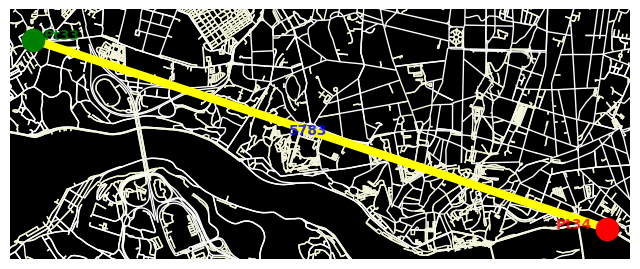

In [421]:
#GENERATION OF FIGURE Y IN THE REPORT
import matplotlib.pyplot as plt 
import geopandas as gp
G = ox.load_graphml(filepath = './' + network_name + '/saved_osmnx_graph')
#not optimal method
def check_if_annotate_points_valid(point, text):
    x = point[0]
    y = point[1]
    textlen = len(text)
    minX_req = textlen * 0.00030 - 0.0012
    if (maxX - x < minX_req): #shift to left if too right
        correction_factor = textlen * 0.00030 - (maxX - x) - 0.0012
        x = x - correction_factor
    return (x, y)

#set as fmm-mapped WSG84 points sequence in the csv file
data_instance = [[-8.612964, 41.140359], [-8.613378, 41.14035], [-8.614215, 41.140278], [-8.614773, 41.140368], [-8.615907, 41.140449], [-8.616609, 41.140602], [-8.618472, 41.141412], [-8.620623, 41.142789], [-8.622558, 41.144094], [-8.62506, 41.144805], [-8.627436, 41.144733], [-8.630082, 41.145174], [-8.6319, 41.146461], [-8.632584, 41.147316], [-8.631252, 41.148774], [-8.629713, 41.150628], [-8.628804, 41.152077], [-8.628579, 41.152464], [-8.62875, 41.152662], [-8.630424, 41.15277], [-8.632683, 41.152779], [-8.635131, 41.152563], [-8.637705, 41.153013], [-8.64036, 41.15358], [-8.642205, 41.154021], [-8.644068, 41.154507], [-8.646453, 41.154336], [-8.648613, 41.1543], [-8.649504, 41.154336], [-8.649837, 41.154354], [-8.649837, 41.1543], [-8.649882, 41.154282], [-8.649936, 41.1543], [-8.6499, 41.154264], [-8.599383, 41.141736], [-8.59653, 41.140566], [-8.65008, 41.154291], [-8.650395, 41.153814], [-8.650377, 41.153832], [-8.650359, 41.153787], [-8.649891, 41.153166], [-8.649369, 41.152572], [-8.649198, 41.152374], [-8.649711, 41.151213], [-8.649117, 41.150466], [-8.649117, 41.149062], [-8.648613, 41.148261], [-8.648424, 41.148225], [-8.647587, 41.148405], [-8.64594, 41.148414], [-8.643861, 41.148135], [-8.642763, 41.148027], [-8.640918, 41.14836], [-8.637759, 41.148351], [-8.635338, 41.147964], [-8.633277, 41.147172], [-8.631513, 41.146146], [-8.629776, 41.14503], [-8.627814, 41.144643], [-8.625996, 41.144769], [-8.624088, 41.144463], [-8.621325, 41.143401], [-8.619444, 41.141961], [-8.617365, 41.140863], [-8.61597, 41.14053]]
data_instance = data_instance[33:35]

latList = []
longList = []
minX, maxX, minY, maxY = 180, -180, 90, -90
#process the trajectory data
for pt in data_instance:
    long, lat = pt[0], pt[1]
    latList.append(lat)
    longList.append(long)
    if minX > long:
        minX = long
    if maxX < long:
        maxX = long
    if minY > lat:
        minY = lat
    if maxY < lat:
        maxY = lat

#Comment the line below if prefer simpler and concise graph used for FMM matching
road_types = []
for x in list(G.edges(data=True)):
    if x[2]['highway'] not in road_types:
        road_types.append(x[2]['highway'])      
G2 = ox.graph.graph_from_bbox(maxY + 0.003, minY - 0.003, minX - 0.003, maxX + 0.003, network_type='all')
ec = ['white' if z['highway'] in road_types else 'beige' for _, _, z in G2.edges(data=True)]
#End#

fig, ax = ox.plot_graph(G2, show=False, close=False,node_alpha=0.5,edge_alpha=1.0, 
                        bgcolor='black',node_color='white', node_size=0, edge_color=ec)
plt.xlim([minX - 0.002,  maxX + 0.002])
plt.ylim([minY - 0.002, maxY + 0.002])

#plot trajectory lines with attribute
plt.plot(longList,latList,"yellow", alpha=1.0, linewidth=6)
#mark start point
plt.plot(longList[0], latList[0], c="green", alpha=1.0, markersize=16, marker ="o")
#mark end point
plt.plot(longList[len(longList)-1], latList[len(latList)-1], c="red", alpha=1.0, markersize=16, marker ="o")

#start/end annotation
ax.annotate("Pt33", (data_instance[0][0]+0.001, data_instance[0][1]), c='green', weight = 'bold', alpha=0.8)
ax.annotate("Pt34", (data_instance[1][0]-0.0045, data_instance[1][1]), c='red', weight = 'bold', alpha=0.8)

#center_pt
center_pt = [-0.0027 + (data_instance[0][0]+data_instance[1][0])/2, (data_instance[0][1]+data_instance[1][1])/2]
harv_dist = int(ox.distance.great_circle_vec(data_instance[0][0], data_instance[0][1], data_instance[1][0], data_instance[1][1]))
ax.annotate(str(harv_dist), center_pt, c='blue', weight = 'bold', alpha=0.8)
print("comparison of trajectoryId:3 gps point pt33 and p34", data_instance[0], data_instance[1])
print("harv dist of 2 pts(m)", harv_dist)
plt.show()

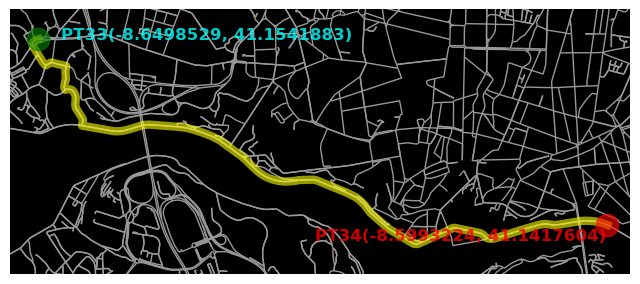

In [396]:
#GENERATION OF Y2 Figure TrajectoryId 03
#https://en.wikipedia.org/wiki/Graph_theory
#https://matplotlib.org/stable/gallery/color/named_colors.html
import matplotlib.pyplot as plt 
import geopandas as gp
network_name = "porto_big"
G = ox.load_graphml(filepath = './' + network_name + '/saved_osmnx_graph')

#pt33/pt34 mapmatching
def find_pt33_pt34_fmm_pts(data):
    pt33_gps_coord, pt34_gps_coord = (-8.6499, 41.154264), (-8.599383, 41.141736)
    pt_33_lowest_dist = [9999, -1]
    pt_34_lowest_dist = [9999, -1]
    for i, instance in enumerate(data):
        x = instance[0]
        y = instance[1]
        harv_dist_33 = ox.distance.great_circle_vec(x, y, pt33_gps_coord[0], pt33_gps_coord[1])
        harv_dist_34 = ox.distance.great_circle_vec(x, y, pt34_gps_coord[0], pt34_gps_coord[1])
        if harv_dist_33 < pt_33_lowest_dist[0]:
            pt_33_lowest_dist[0] = harv_dist_33
            pt_33_lowest_dist[1] = i
        if harv_dist_34 < pt_34_lowest_dist[0]:
            pt_34_lowest_dist[0] = harv_dist_34
            pt_34_lowest_dist[1] = i
    idx_33, idx_34 = pt_33_lowest_dist[1], pt_34_lowest_dist[1]
    #pt33_fmm_cord, pt_34_fmm_coord = data[idx_33], data[idx_34]
    return idx_33, idx_34

#not optimal method
def check_if_annotate_points_valid(point, text):
    x = point[0]
    y = point[1]
    textlen = len(text)
    minX_req = textlen * 0.00030 - 0.0012
    if (maxX - x < minX_req): #shift to left if too right
        correction_factor = textlen * 0.00030 - (maxX - x) - 0.0012
        x = x - correction_factor
    return (x, y)

idx_33, idx_34 = find_pt33_pt34_fmm_pts(data_instance)
data_instance_33_34 = data_instance[idx_33:idx_34 + 1]

latList = [] #Save y coordinate
longList = [] #Save x coordinate
minX, maxX, minY, maxY = 180, -180, 90, -90
#process the trajectory data
for pt in data_instance_33_34:
    long, lat = pt[0], pt[1]
    latList.append(lat)
    longList.append(long)
    if minX > long:
        minX = long
    if maxX < long:
        maxX = long
    if minY > lat:
        minY = lat
    if maxY < lat:
        maxY = lat

fig, ax = ox.plot_graph(G, show=False, close=False,node_alpha=0.5,edge_alpha=1.0, 
                        bgcolor='black',node_color='white', node_size=0)

plt.xlim([minX - 0.002,  maxX + 0.002])
plt.ylim([minY - 0.002, maxY + 0.002])

#plot trajectory lines with attribute
plt.plot(longList,latList,"yellow", alpha=0.6, linewidth=6)
#mark start point
plt.plot(longList[0], latList[0], c="green", alpha=0.6, markersize=16, marker ="o")
#mark end point
plt.plot(longList[len(longList)-1], latList[len(latList)-1], c="red", alpha=0.6, markersize=16, marker ="o")
ax.annotate(text="PT33" + str((longList[0], latList[0])), xy=(longList[0] + 0.002, latList[0]), weight = 'bold', 
            c='cyan', size=12, alpha = 0.8)
ax.annotate(text="PT34" + str((longList[len(longList)-1], latList[len(latList)-1])), 
            xy=(longList[len(longList)-1] - 0.026, latList[len(latList)-1]-0.001), weight = 'bold', 
            c='red', size=12, alpha = 0.8)
plt.show()

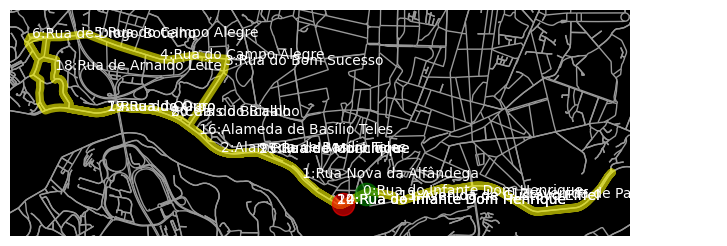

In [420]:
#GENERATION OF Y3 Figure TrajectoryId 03
#https://en.wikipedia.org/wiki/Graph_theory
#https://matplotlib.org/stable/gallery/color/named_colors.html

#Annotation is not optimal and the produced figure was brought to photo edit software 
#for further editing before being used for report
import matplotlib.pyplot as plt 
import geopandas as gp
network_name = "porto_big"
G = ox.load_graphml(filepath = './' + network_name + '/saved_osmnx_graph')

#not optimal method
def check_if_annotate_points_valid(point, text):
    x = point[0]
    y = point[1]
    textlen = len(text)
    minX_req = textlen * 0.00030 - 0.0012
    if (maxX - x < minX_req): #shift to left if too right
        correction_factor = textlen * 0.00030 - (maxX - x) - 0.0012
        x = x - correction_factor
    return (x, y)


output_cpath = [55685, 698, 55684, 63436, 56596, 57098, 61024, 2726, 1082, 693, 8590, 61012, 8589, 690, 8573, 17075, 3596, 5452, 2716, 1322, 1324, 53922, 40149, 61020, 40147, 4531, 68099, 8627, 8625, 4148, 4150, 8620, 4157, 1314, 8666, 54765, 56400, 4275, 1311, 71664, 1312, 5612, 1294, 53935, 53933, 4429, 3586, 3590, 64799, 673, 676, 679, 688, 689, 8588, 61011, 8592, 692, 1084, 2725, 61023, 57097, 56595, 63435, 55685, 696, 26090, 53876, 50871, 53875, 26089, 698, 55684, 63436, 56596, 57098, 61024, 2726, 1082, 693, 8590, 61012, 8589, 691, 687, 678, 677, 675, 64800, 3589, 3587, 56396, 56400, 4274, 4276, 4277, 1312, 5612, 1294, 53935, 53933, 4428, 3585, 3582, 8760, 2709, 673, 676, 679, 688, 689, 8588, 61011, 8592, 692, 1084, 2725]
data_instance = [[-8.6135064, 41.1413711], [-8.6134714, 41.1413899], [-8.613438, 41.1414248], [-8.6134947, 41.1414352], 
                 [-8.6135399, 41.1414352], [-8.6142213, 41.1412132], [-8.6142611, 41.1411907], [-8.614278, 41.1411531], 
                 [-8.6144781, 41.1410814], [-8.6145579, 41.1410517], [-8.6146391, 41.1410216], [-8.6146916, 41.1410021], 
                 [-8.6150578, 41.1408658], [-8.615197, 41.140814], [-8.6152285, 41.1408037], [-8.6153165, 41.140775], 
                 [-8.615393, 41.1407501], [-8.6154822, 41.1407199], [-8.6157974, 41.1406159], [-8.6160216, 41.1405362], 
                 [-8.6160826, 41.1405194], [-8.6161892, 41.14049], [-8.6163213, 41.1404856], [-8.6163459, 41.1404877], 
                 [-8.6164684, 41.1404984], [-8.6165973, 41.1405354], [-8.6174342, 41.1409169], [-8.6182629, 41.1412923], 
                 [-8.6183463, 41.1413301], [-8.6187144, 41.1414968], [-8.6188491, 41.1415819], [-8.6198235, 41.1422183], 
                 [-8.6200853, 41.1423893], [-8.6202318, 41.1424899], [-8.6203556, 41.1425748], [-8.6209478, 41.143157], 
                 [-8.6212837, 41.1433979], [-8.6213339, 41.1434339], [-8.6216294, 41.1435982], [-8.6216904, 41.1436237], 
                 [-8.6220438, 41.1437713], [-8.6225335, 41.1439489], [-8.6231598, 41.1441377], [-8.6235745, 41.1442647], 
                 [-8.6243174, 41.1444938], [-8.6247666, 41.1446324], [-8.6250934, 41.144735], [-8.6254106, 41.1447932], 
                 [-8.6266799, 41.1447604], [-8.6267551, 41.1447585], [-8.6268987, 41.1447278], [-8.627037, 41.1447131], 
                 [-8.6271975, 41.1446999], [-8.6273413, 41.144688], [-8.6274999, 41.1446775], [-8.6276791, 41.1446698], 
                 [-8.6278804, 41.1446649], [-8.6280428, 41.1446678], [-8.6282135, 41.1446783], [-8.6284404, 41.1446987], 
                 [-8.6286688, 41.1447307], [-8.628864, 41.1447635], [-8.6290926, 41.1448166], [-8.6292898, 41.1448676], 
                 [-8.6294324, 41.1449121], [-8.6295694, 41.1449608], [-8.629633, 41.1449846], [-8.6297382, 41.145024], 
                 [-8.6299469, 41.1451205], [-8.6301362, 41.1452162], [-8.6303271, 41.1453239], [-8.6307201, 41.145592], 
                 [-8.6307923, 41.1456411], [-8.6314509, 41.1461372], [-8.6315556, 41.1462038], [-8.6316434, 41.1462596], 
                 [-8.6318066, 41.1463634], [-8.6326775, 41.1468428], [-8.6328764, 41.146954], [-8.6327796, 41.1470617], 
                 [-8.6327668, 41.1470766], [-8.6327023, 41.1471513], [-8.6326805, 41.1471766], [-8.631553, 41.1484527], 
                 [-8.6314991, 41.1485138], [-8.6310069, 41.1490819], [-8.6308723, 41.1492373], [-8.6307611, 41.1493656], 
                 [-8.6302954, 41.1499033], [-8.6299508, 41.1503011], [-8.6295157, 41.1508085], [-8.6294233, 41.1509158], 
                 [-8.6293113, 41.1510435], [-8.6291323, 41.1512455], [-8.6290736, 41.1513117], [-8.6289862, 41.1514767], 
                 [-8.6289736, 41.1515796], [-8.6287691, 41.1523766], [-8.628743, 41.1524782], [-8.6289655, 41.1524906], 
                 [-8.6296472, 41.1525286], [-8.6301016, 41.152554], [-8.6304904, 41.1525757], [-8.6306176, 41.1525836], 
                 [-8.6308068, 41.1525922], [-8.6309917, 41.1526006], [-8.6313575, 41.1526165], [-8.6314821, 41.1526802], 
                 [-8.6321685, 41.1527301], [-8.6323388, 41.1527262], [-8.6323916, 41.1527199], [-8.6324663, 41.1527113], 
                 [-8.6326352, 41.1526917], [-8.6328135, 41.152688], [-8.6328921, 41.1526593], [-8.6331975, 41.1526205], 
                 [-8.633479, 41.1525859], [-8.6335202, 41.1525796], [-8.6335704, 41.1525732], [-8.6339491, 41.1525251], 
                 [-8.6341695, 41.1524971], [-8.6343718, 41.1524692], [-8.6344234, 41.1524621], [-8.6345977, 41.1524387], 
                 [-8.6347003, 41.1524249], [-8.6348243, 41.1524083], [-8.6350422, 41.1524106], [-8.6355022, 41.152436], 
                 [-8.6359434, 41.1524604], [-8.6362346, 41.1525246], [-8.6363837, 41.1525575], [-8.6366768, 41.1526253], 
                 [-8.6368042, 41.1526548], [-8.63737, 41.1527919], [-8.6375345, 41.1528317], [-8.6381943, 41.1529858], 
                 [-8.6385893, 41.1530728], [-8.6387697, 41.153116], [-8.6401584, 41.1534455], [-8.6402681, 41.1534715], 
                 [-8.640383, 41.1535], [-8.640814, 41.1536068], [-8.641801, 41.1538865], [-8.6422632, 41.1540236], 
                 [-8.6423882, 41.1540607], [-8.6424267, 41.154071], [-8.6426014, 41.1541232], [-8.6438478, 41.1544954], 
                 [-8.6438876, 41.1545048], [-8.6439428, 41.1545061], [-8.6441986, 41.1544872], [-8.6454889, 41.1543736], 
                 [-8.646026, 41.1543254], [-8.6468463, 41.1542645], [-8.6480673, 41.1542633], [-8.6481883, 41.1542667], 
                 [-8.6483268, 41.154247], [-8.6484644, 41.1542784], [-8.6490215, 41.1543329], [-8.6492137, 41.1543467], 
                 [-8.6492759, 41.1542842], [-8.6493644, 41.1542436], [-8.6494243, 41.1542293], [-8.6494929, 41.1542194], 
                 [-8.6496389, 41.1542172], [-8.6497277, 41.1542127], [-8.6498529, 41.1541883], [-8.6499598, 41.1541698], 
                 [-8.650074, 41.1541261], [-8.6502034, 41.1540473], [-8.6502796, 41.1539777], [-8.650349, 41.1538878], 
                 [-8.6503445, 41.1538051], [-8.6502971, 41.1537015], [-8.650078, 41.153431], [-8.6498971, 41.1532061], 
                 [-8.6498367, 41.153131], [-8.6498099, 41.1530976], [-8.6497761, 41.1530555], [-8.6494393, 41.1526413], 
                 [-8.6494193, 41.1526221], [-8.6492417, 41.1524757], [-8.6491802, 41.1524367], [-8.6490662, 41.1524744], 
                 [-8.6487821, 41.1525933], [-8.6487086, 41.1526308], [-8.6486399, 41.1526182], [-8.6473533, 41.1523824], 
                 [-8.6474117, 41.1521568], [-8.6474295, 41.1519936], [-8.6474123, 41.1518156], [-8.6473998, 41.1516743], 
                 [-8.6473892, 41.1515022], [-8.6474604, 41.1513318], [-8.6475143, 41.151145], [-8.6475346, 41.1509506], 
                 [-8.6474988, 41.150859], [-8.647423, 41.1507947], [-8.6473081, 41.150838], [-8.6471386, 41.1508403], 
                 [-8.6469267, 41.1508107], [-8.6468389, 41.1507736], [-8.6467669, 41.1507246], [-8.6466565, 41.1506289], 
                 [-8.6466067, 41.1505456], [-8.6465259, 41.1503601], [-8.6465111, 41.1502774], [-8.6465513, 41.1498891], 
                 [-8.6465543, 41.1497871], [-8.646534, 41.1496799], [-8.6464722, 41.1495421], [-8.645887, 41.1488547], 
                 [-8.6458668, 41.1487754], [-8.6459235, 41.1485017], [-8.6459294, 41.1484732], [-8.6459497, 41.148402], 
                 [-8.6457443, 41.1483728], [-8.6431456, 41.1480334], [-8.6429337, 41.1480233], [-8.6427201, 41.1480275], 
                 [-8.6424342, 41.1480489], [-8.642183, 41.1480796], [-8.6418667, 41.1481347], [-8.6415429, 41.1482073], 
                 [-8.6409263, 41.1483551], [-8.6405896, 41.1484311], [-8.6402582, 41.1484598], [-8.6399939, 41.1484717], 
                 [-8.6386158, 41.1483953], [-8.6375375, 41.1483305], [-8.6370282, 41.1482938], [-8.6368506, 41.1482719], 
                 [-8.636537, 41.1482282], [-8.6359246, 41.1481085], [-8.6353043, 41.1479468], [-8.6349636, 41.1478484], 
                 [-8.6344362, 41.1476992], [-8.6338769, 41.1474847], [-8.6337433, 41.1474276], [-8.6330857, 41.1470684], 
                 [-8.6328764, 41.146954], [-8.6326775, 41.1468428], [-8.6318066, 41.1463634], [-8.6316434, 41.1462596], 
                 [-8.6315556, 41.1462038], [-8.6314509, 41.1461372], [-8.6307923, 41.1456411], [-8.6307201, 41.145592], 
                 [-8.6303271, 41.1453239], [-8.6301362, 41.1452162], [-8.6299469, 41.1451205], [-8.6297382, 41.145024], 
                 [-8.629633, 41.1449846], [-8.6295694, 41.1449608], [-8.6294324, 41.1449121], [-8.6292898, 41.1448676], 
                 [-8.6290926, 41.1448166], [-8.628864, 41.1447635], [-8.6286688, 41.1447307], [-8.6284404, 41.1446987], 
                 [-8.6282135, 41.1446783], [-8.6280428, 41.1446678], [-8.6278804, 41.1446649], [-8.6276791, 41.1446698], 
                 [-8.6274999, 41.1446775], [-8.6273413, 41.144688], [-8.6271975, 41.1446999], [-8.627037, 41.1447131], 
                 [-8.6268987, 41.1447278], [-8.6267551, 41.1447585], [-8.6266799, 41.1447604], [-8.6254106, 41.1447932], 
                 [-8.6250934, 41.144735], [-8.6247666, 41.1446324], [-8.6243174, 41.1444938], [-8.6235745, 41.1442647], 
                 [-8.6231598, 41.1441377], [-8.6225335, 41.1439489], [-8.6220438, 41.1437713], [-8.6216904, 41.1436237], 
                 [-8.6216294, 41.1435982], [-8.6213339, 41.1434339], [-8.6212837, 41.1433979], [-8.6209478, 41.143157], 
                 [-8.6203556, 41.1425748], [-8.6202318, 41.1424899], [-8.6200853, 41.1423893], [-8.6198235, 41.1422183], 
                 [-8.6188491, 41.1415819], [-8.6187144, 41.1414968], [-8.6183463, 41.1413301], [-8.6182629, 41.1412923], 
                 [-8.6174342, 41.1409169], [-8.6165973, 41.1405354], [-8.6164684, 41.1404984], [-8.6163459, 41.1404877], 
                 [-8.6163213, 41.1404856], [-8.6161892, 41.14049], [-8.6160826, 41.1405194], [-8.6160216, 41.1405362], 
                 [-8.6157974, 41.1406159], [-8.6154822, 41.1407199], [-8.615393, 41.1407501], [-8.6153165, 41.140775], 
                 [-8.6152285, 41.1408037], [-8.615197, 41.140814], [-8.6150578, 41.1408658], [-8.6146916, 41.1410021], 
                 [-8.6146391, 41.1410216], [-8.6145579, 41.1410517], [-8.6144781, 41.1410814], [-8.614278, 41.1411531], 
                 [-8.6142386, 41.1411442], [-8.6141924, 41.1411442], [-8.6135064, 41.1413711], [-8.6134714, 41.1413899], 
                 [-8.613438, 41.1414248], [-8.6133688, 41.1414459], [-8.6130631, 41.1415571], [-8.6130147, 41.1415691], 
                 [-8.6129477, 41.1415745], [-8.6128692, 41.1415688], [-8.6108132, 41.1412582], [-8.6107193, 41.1412393], 
                 [-8.6105577, 41.1411964], [-8.6103971, 41.1411295], [-8.6102814, 41.1410531], [-8.6101667, 41.1409752], 
                 [-8.6100912, 41.1409282], [-8.6100138, 41.1408932], [-8.6099196, 41.1408664], [-8.6098466, 41.1408556], 
                 [-8.6097218, 41.1408406], [-8.6096474, 41.1408361], [-8.6095399, 41.1408427], [-8.6093941, 41.1408586], 
                 [-8.6091553, 41.1409062], [-8.6089187, 41.1409654], [-8.6073979, 41.1413288], [-8.607256, 41.1413612], 
                 [-8.6060005, 41.1416454], [-8.6053578, 41.1417817], [-8.6052058, 41.1418007], [-8.6049702, 41.1418291], 
                 [-8.6047517, 41.1418317], [-8.604549, 41.1418105], [-8.6044658, 41.1418008], [-8.6042568, 41.1417727], 
                 [-8.6039886, 41.1417594], [-8.6036183, 41.1417898], [-8.6027466, 41.1418973], [-8.6016708, 41.1420294], 
                 [-8.6012758, 41.1420457], [-8.6008666, 41.142038], [-8.6004706, 41.1420094], [-8.6000628, 41.1419492], 
                 [-8.5996175, 41.1418424], [-8.5993224, 41.1417604], [-8.5990934, 41.1416731], [-8.5985669, 41.1414528], 
                 [-8.5983884, 41.1413709], [-8.5973512, 41.1409148], [-8.5961053, 41.1403349], [-8.5960126, 41.1402909], 
                 [-8.5955137, 41.1400658], [-8.5953472, 41.1400048], [-8.5951064, 41.1399492], [-8.5949254, 41.1399239], 
                 [-8.594702, 41.1399093], [-8.59369, 41.1399903], [-8.5907859, 41.1402182], [-8.5904321, 41.140252], 
                 [-8.5901145, 41.1403299], [-8.5898428, 41.1404441], [-8.5895852, 41.1405769], [-8.5894586, 41.1406541], 
                 [-8.5893198, 41.1407388], [-8.5889041, 41.1410538], [-8.5883493, 41.141429], [-8.5878536, 41.141836], 
                 [-8.5876888, 41.1420236], [-8.5871563, 41.1426605], [-8.5870674, 41.1427645], [-8.5869893, 41.1428449], 
                 [-8.5867621, 41.1430393], [-8.5866474, 41.1431219], [-8.5867621, 41.1430393], [-8.5869893, 41.1428449], 
                 [-8.5870674, 41.1427645], [-8.5871563, 41.1426605], [-8.5876888, 41.1420236], [-8.5878536, 41.141836], [-8.5883493, 41.141429], [-8.5889041, 41.1410538], [-8.5893198, 41.1407388], [-8.5894586, 41.1406541], [-8.5895852, 41.1405769], [-8.5898428, 41.1404441], [-8.5901145, 41.1403299], [-8.5904321, 41.140252], [-8.5907859, 41.1402182], [-8.59369, 41.1399903], [-8.594702, 41.1399093], [-8.5949254, 41.1399239], [-8.5951064, 41.1399492], [-8.5953472, 41.1400048], [-8.5955137, 41.1400658], [-8.5960126, 41.1402909], [-8.5961053, 41.1403349], [-8.5973512, 41.1409148], [-8.5983884, 41.1413709], [-8.5985669, 41.1414528], [-8.5990934, 41.1416731], [-8.5993224, 41.1417604], [-8.5996175, 41.1418424], [-8.6000628, 41.1419492], [-8.6004706, 41.1420094], [-8.6008666, 41.142038], [-8.6012758, 41.1420457], [-8.6016708, 41.1420294], [-8.6027466, 41.1418973], [-8.6036183, 41.1417898], [-8.6039886, 41.1417594], [-8.6042568, 41.1417727], [-8.6044658, 41.1418008], [-8.604549, 41.1418105], [-8.6047517, 41.1418317], [-8.6049702, 41.1418291], [-8.6052058, 41.1418007], [-8.6053578, 41.1417817], [-8.6060005, 41.1416454], [-8.607256, 41.1413612], [-8.6073979, 41.1413288], [-8.6089187, 41.1409654], [-8.6091553, 41.1409062], [-8.6093941, 41.1408586], [-8.6095399, 41.1408427], [-8.6096474, 41.1408361], [-8.6097218, 41.1408406], [-8.6098466, 41.1408556], [-8.6099196, 41.1408664], [-8.6100138, 41.1408932], [-8.6100912, 41.1409282], [-8.6101667, 41.1409752], [-8.6102814, 41.1410531], [-8.6103971, 41.1411295], [-8.6105577, 41.1411964], [-8.6107193, 41.1412393], [-8.6108132, 41.1412582], [-8.6128692, 41.1415688], [-8.6129477, 41.1415745], [-8.6130147, 41.1415691], [-8.6130631, 41.1415571], [-8.6133688, 41.1414459], [-8.613438, 41.1414248], [-8.6134947, 41.1414352], [-8.6135399, 41.1414352], [-8.6142213, 41.1412132], [-8.6142611, 41.1411907], [-8.614278, 41.1411531], [-8.6144781, 41.1410814], [-8.6145579, 41.1410517], [-8.6146391, 41.1410216], [-8.6146916, 41.1410021], [-8.6150578, 41.1408658], [-8.615197, 41.140814], [-8.6152285, 41.1408037], [-8.6153165, 41.140775], [-8.615393, 41.1407501], [-8.6154822, 41.1407199], [-8.6157974, 41.1406159], [-8.6160216, 41.1405362], [-8.6160826, 41.1405194], [-8.6161892, 41.14049], [-8.6163213, 41.1404856], [-8.6163459, 41.1404877], [-8.6164684, 41.1404984], [-8.6165973, 41.1405354], [-8.6174342, 41.1409169], [-8.6182629, 41.1412923], [-8.6183463, 41.1413301], [-8.6187144, 41.1414968], [-8.6188491, 41.1415819], [-8.6198235, 41.1422183], [-8.6200853, 41.1423893], [-8.6202318, 41.1424899], [-8.6203556, 41.1425748], [-8.6209478, 41.143157], [-8.6212837, 41.1433979], [-8.6213339, 41.1434339], [-8.6216294, 41.1435982], [-8.6216904, 41.1436237], [-8.6220438, 41.1437713], [-8.6225335, 41.1439489], [-8.6231598, 41.1441377], [-8.6235745, 41.1442647], [-8.6243174, 41.1444938], [-8.6247666, 41.1446324], [-8.6250934, 41.144735], [-8.6254106, 41.1447932], [-8.6266799, 41.1447604], [-8.6267551, 41.1447585], [-8.6268987, 41.1447278], [-8.627037, 41.1447131], [-8.6271975, 41.1446999], [-8.6273413, 41.144688], [-8.6274999, 41.1446775], [-8.6276791, 41.1446698], [-8.6278804, 41.1446649], [-8.6280428, 41.1446678], [-8.6282135, 41.1446783], [-8.6284404, 41.1446987], [-8.6286688, 41.1447307], [-8.628864, 41.1447635], [-8.6290926, 41.1448166], [-8.6292898, 41.1448676], [-8.6294324, 41.1449121], [-8.6295694, 41.1449608], [-8.629633, 41.1449846], [-8.6297382, 41.145024], [-8.6299469, 41.1451205], [-8.6301362, 41.1452162], [-8.6303271, 41.1453239], [-8.6307201, 41.145592], [-8.6307923, 41.1456411], [-8.6314509, 41.1461372], [-8.6315556, 41.1462038], [-8.6316434, 41.1462596], [-8.6318066, 41.1463634], [-8.6326775, 41.1468428], [-8.6328764, 41.146954], [-8.6330857, 41.1470684], [-8.6337433, 41.1474276], [-8.6338769, 41.1474847], [-8.6344362, 41.1476992], [-8.6349636, 41.1478484], [-8.6353043, 41.1479468], [-8.6359246, 41.1481085], [-8.636537, 41.1482282], [-8.6368506, 41.1482719], [-8.6370282, 41.1482938], [-8.6375375, 41.1483305], [-8.6386158, 41.1483953], [-8.6399939, 41.1484717], [-8.6402582, 41.1484598], [-8.6405896, 41.1484311], [-8.6409263, 41.1483551], [-8.6415429, 41.1482073], [-8.6418667, 41.1481347], [-8.642183, 41.1480796], [-8.6424342, 41.1480489], [-8.6427201, 41.1480275], [-8.6429337, 41.1480233], [-8.6431456, 41.1480334], [-8.6457443, 41.1483728], [-8.6459497, 41.148402], [-8.6459294, 41.1484732], [-8.6459235, 41.1485017], [-8.6458668, 41.1487754], [-8.645887, 41.1488547], [-8.6464722, 41.1495421], [-8.646534, 41.1496799], [-8.6465543, 41.1497871], [-8.6465513, 41.1498891], [-8.6465111, 41.1502774], [-8.6465259, 41.1503601], [-8.6466067, 41.1505456], [-8.6466565, 41.1506289], [-8.6467669, 41.1507246], [-8.6468389, 41.1507736], [-8.6469267, 41.1508107], [-8.6471386, 41.1508403], [-8.6473081, 41.150838], [-8.647423, 41.1507947], [-8.6474988, 41.150859], [-8.6475346, 41.1509506], [-8.6475143, 41.151145], [-8.6474604, 41.1513318], [-8.6473892, 41.1515022], [-8.6473998, 41.1516743], [-8.6474123, 41.1518156], [-8.6474295, 41.1519936], [-8.6474117, 41.1521568], [-8.6473533, 41.1523824], [-8.6486399, 41.1526182], [-8.6487086, 41.1526308], [-8.6486189, 41.1527347], [-8.6485695, 41.1528641], [-8.6484636, 41.1534552], [-8.6483684, 41.1540452], [-8.6483431, 41.1541659], [-8.6483268, 41.154247], [-8.6484644, 41.1542784], [-8.6490215, 41.1543329], [-8.6492137, 41.1543467], [-8.6493689, 41.1543242], [-8.6495448, 41.1543042], [-8.6500288, 41.1542492], [-8.6501468, 41.1542562], [-8.6501815, 41.1541976], [-8.6502034, 41.1540473], [-8.6502796, 41.1539777], [-8.650349, 41.1538878], [-8.6503445, 41.1538051], [-8.6502971, 41.1537015], [-8.650078, 41.153431], [-8.6498971, 41.1532061], [-8.6498367, 41.153131], [-8.6498099, 41.1530976], [-8.6497761, 41.1530555], [-8.6494393, 41.1526413], [-8.6494193, 41.1526221], [-8.6492417, 41.1524757], [-8.6491802, 41.1524367], [-8.6492079, 41.1523882], [-8.6494836, 41.1516598], [-8.649746, 41.1512183], [-8.6498075, 41.1511582], [-8.6495069, 41.1510045], [-8.6494351, 41.1509651], [-8.6490788, 41.1507787], [-8.6490475, 41.1507509], [-8.6490342, 41.1506755], [-8.6490593, 41.1504011], [-8.6490494, 41.1501962], [-8.6490427, 41.1501051], [-8.6490909, 41.1499054], [-8.6491428, 41.1496926], [-8.6490888, 41.1490695], [-8.6490598, 41.1489474], [-8.6488801, 41.1486533], [-8.6485839, 41.1483526], [-8.6485352, 41.1483031], [-8.6484771, 41.1482384], [-8.6479638, 41.1483674], [-8.6475927, 41.1484217], [-8.6474164, 41.1484475], [-8.6469042, 41.1484748], [-8.6464234, 41.148458], [-8.6461764, 41.1484325], [-8.6459497, 41.148402], [-8.6457443, 41.1483728], [-8.6431456, 41.1480334], [-8.6429337, 41.1480233], [-8.6427201, 41.1480275], [-8.6424342, 41.1480489], [-8.642183, 41.1480796], [-8.6418667, 41.1481347], [-8.6415429, 41.1482073], [-8.6409263, 41.1483551], [-8.6405896, 41.1484311], [-8.6402582, 41.1484598], [-8.6399939, 41.1484717], [-8.6386158, 41.1483953], [-8.6375375, 41.1483305], [-8.6370282, 41.1482938], [-8.6368506, 41.1482719], [-8.636537, 41.1482282], [-8.6359246, 41.1481085], [-8.6353043, 41.1479468], [-8.6349636, 41.1478484], [-8.6344362, 41.1476992], [-8.6338769, 41.1474847], [-8.6337433, 41.1474276], [-8.6330857, 41.1470684], [-8.6328764, 41.146954], [-8.6326775, 41.1468428], [-8.6318066, 41.1463634], [-8.6316434, 41.1462596], [-8.6315556, 41.1462038], [-8.6314509, 41.1461372], [-8.6307923, 41.1456411], [-8.6307201, 41.145592], [-8.6303271, 41.1453239], [-8.6301362, 41.1452162], [-8.6299469, 41.1451205], [-8.6297382, 41.145024], [-8.629633, 41.1449846], [-8.6295694, 41.1449608], [-8.6294324, 41.1449121], [-8.6292898, 41.1448676], [-8.6290926, 41.1448166], [-8.628864, 41.1447635], [-8.6286688, 41.1447307], [-8.6284404, 41.1446987], [-8.6282135, 41.1446783], [-8.6280428, 41.1446678], [-8.6278804, 41.1446649], [-8.6276791, 41.1446698], [-8.6274999, 41.1446775], [-8.6273413, 41.144688], [-8.6271975, 41.1446999], [-8.627037, 41.1447131], [-8.6268987, 41.1447278], [-8.6267551, 41.1447585], [-8.6266799, 41.1447604], [-8.6254106, 41.1447932], [-8.6250934, 41.144735], [-8.6247666, 41.1446324], [-8.6243174, 41.1444938], [-8.6235745, 41.1442647], [-8.6231598, 41.1441377], [-8.6225335, 41.1439489], [-8.6220438, 41.1437713], [-8.6216904, 41.1436237], [-8.6216294, 41.1435982], [-8.6213339, 41.1434339], [-8.6212837, 41.1433979], [-8.6209478, 41.143157], [-8.6203556, 41.1425748], [-8.6202318, 41.1424899], [-8.6200853, 41.1423893], [-8.6198235, 41.1422183], [-8.6188491, 41.1415819], [-8.6187144, 41.1414968], [-8.6183463, 41.1413301], [-8.6182629, 41.1412923], [-8.6174342, 41.1409169], [-8.6165973, 41.1405354], [-8.6164684, 41.1404984], [-8.6163459, 41.1404877], [-8.6163213, 41.1404856], [-8.6161892, 41.14049], [-8.6160826, 41.1405194], [-8.6160216, 41.1405362], [-8.61597774588, 41.1405517895]]
#route
#extract edge and node high level information data for visual annotation and decoration work
nodes_shp = gp.GeoDataFrame.from_file(network_name + "/nodes.shp")
edges_shp = gp.GeoDataFrame.from_file(network_name + "/edges.shp")
edges_sequence = [edges_shp[x:x+1] for x in output_cpath]
nodes_sequence = [int(edge['u']) for edge in edges_sequence]

latList = [] #Save y coordinate
longList = [] #Save x coordinate
#calculate the min max points so we know where to focus and zoom into relevant space, 
#essential to ensure optimal visual 
minX, maxX, minY, maxY = 180, -180, 90, -90

#process the trajectory data
for pt in data_instance:
    long, lat = pt[0], pt[1]
    latList.append(lat)
    longList.append(long)
    if minX > long:
        minX = long
    if maxX < long:
        maxX = long
    if minY > lat:
        minY = lat
    if maxY < lat:
        maxY = lat

fig, ax = ox.plot_graph(G, show=False, close=False,node_alpha=0.5,edge_alpha=1.0, 
                        bgcolor='black',node_color='white', node_size=0)

plt.xlim([minX - 0.002,  maxX + 0.002])
plt.ylim([minY - 0.002, maxY + 0.002])

#plot trajectory lines with attribute
plt.plot(longList,latList,"yellow", alpha=0.6, linewidth=6)
#mark start point
plt.plot(longList[0], latList[0], c="green", alpha=0.6, markersize=16, marker ="o")
#mark end point
plt.plot(longList[len(longList)-1], latList[len(latList)-1], c="red", alpha=0.6, markersize=16, marker ="o")


#Annotation code
text_list = []
last_edge_id = -1
last_text = ""
for i, edge in enumerate(edges_sequence):
    c = edge['geometry'].iloc[0].interpolate(0.5, normalized = True)
    if last_edge_id == -1 or i == len(edges_sequence): #always annotate start and end points
        harv_dist = 0
        text = str(edge['name'].iloc[0])
        if '[' or ']' in text:
            text = text.split(",")[0].strip(":[\'")
        text = str(len(text_list)) +":" + text
        text_list.append(text)
        annotate_point = check_if_annotate_points_valid((c.x, c.y), text)
        ax.annotate(text, (annotate_point[0], annotate_point[1]), c='w')
        last_text =  text 
        last_edge_id = i
    else:
        last_c = edges_sequence[last_edge_id]['geometry'].iloc[0].interpolate(0.5, normalized = True)
        harv_dist = ox.distance.great_circle_vec(c.x, c.y, last_c.x, last_c.y)
        text = str(len(text_list)) +":" +str(edge['name'].iloc[0])
        if text == None:
            continue
        if harv_dist >= annotation_interval and last_text != text: #annotate point with text is diff from last annotation
            text = str(edge['name'].iloc[0])
            if '[' or ']' in text:
                text = text.split(",")[0].strip(":[\'")
            text = str(len(text_list)) +":" + text
            text_list.append(text)
            annotate_point = check_if_annotate_points_valid((c.x, c.y), text)
            ax.annotate(text, (annotate_point[0], annotate_point[1]), c='w') # 1 wsg84 point degree = 111km
            last_text = text
            last_edge_id = i
        elif harv_dist >= 5 * annotation_interval and last_text == text: #if annotation is same as previous annotation, repeat lesser
            text = str(edge['name'].iloc[0])
            if '[' or ']' in text:
                text = text.split(",")[0].strip(":[\'")
            text = str(len(text_list)) +":" + text
            text_list.append(text)
            annotate_point = check_if_annotate_points_valid((c.x, c.y), text)
            ax.annotate(text, (annotate_point[0], annotate_point[1]), c='w')
            last_text = text
            last_edge_id = i
plt.show()

In [ ]:
#print the generated road names to annotate
text_list

comparison of trajectoryId:979 gps point pt34 and p35 [-8.532585, 41.137515] [-8.639334, 41.139018]
harv dist of 2 pts(m) 11871


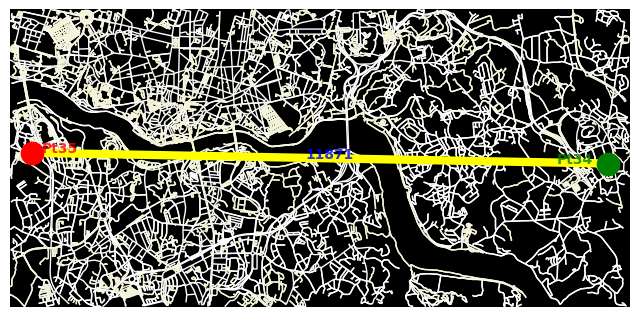

In [412]:
#GENERATION OF FIGURE Z IN THE REPORT
conclusion_979 = [[-8.585631, 41.148585], [-8.585703, 41.148657], [-8.585685, 41.148765], [-8.585892, 41.148963], [-8.586342, 41.148882], [-8.586207, 41.148207], [-8.587008, 41.147514], [-8.587134, 41.147415], [-8.586675, 41.147136], [-8.584902, 41.146623], [-8.583525, 41.145642], [-8.581716, 41.144769], [-8.579583, 41.145579], [-8.578935, 41.146101], [-8.580681, 41.146974], [-8.580366, 41.149341], [-8.576199, 41.151033], [-8.572761, 41.153598], [-8.571231, 41.15691], [-8.567388, 41.158512], [-8.562447, 41.158584], [-8.55855, 41.156091], [-8.553555, 41.154858], [-8.549406, 41.15268], [-8.547903, 41.148882], [-8.547075, 41.144967], [-8.544528, 41.141925], [-8.540595, 41.13972], [-8.538579, 41.136543], [-8.537661, 41.135094], [-8.53605, 41.136201], [-8.534862, 41.136885], [-8.533998, 41.136372], [-8.532918, 41.136957], [-8.532585, 41.137515], [-8.639334, 41.139018], [-8.638722, 41.138883], [-8.53263, 41.137578], [-8.532666, 41.137614], [-8.532603, 41.137272], [-8.533395, 41.136804], [-8.534205, 41.13648], [-8.53362, 41.13567], [-8.534862, 41.135562], [-8.535564, 41.136705], [-8.537067, 41.136111], [-8.539299, 41.13792], [-8.541846, 41.141115], [-8.546121, 41.143194], [-8.547471, 41.147127], [-8.548479, 41.151357], [-8.552367, 41.154696], [-8.557632, 41.15583], [-8.561619, 41.158206], [-8.566209, 41.158422], [-8.571888, 41.15655], [-8.573616, 41.15295], [-8.577414, 41.150394], [-8.58141, 41.148612], [-8.579736, 41.146281], [-8.580438, 41.145147], [-8.582778, 41.145066], [-8.584119, 41.146146], [-8.584488, 41.146524], [-8.585046, 41.146677], [-8.585811, 41.146929], [-8.586144, 41.147019], [-8.586639, 41.147109], [-8.587035, 41.147469], [-8.586594, 41.14764], [-8.586432, 41.147721], [-8.586153, 41.148126], [-8.585955, 41.148783]]
pt_979_failed_idx = (34, 35)
pt_979_failed_pts = (conclusion_979[34], conclusion_979[35])
pt_979_failed_pts

import matplotlib.pyplot as plt 
import geopandas as gp

G = ox.load_graphml(filepath = './' + network_name + '/saved_osmnx_graph')
#not optimal method
def check_if_annotate_points_valid(point, text):
    x = point[0]
    y = point[1]
    textlen = len(text)
    minX_req = textlen * 0.00030 - 0.0012
    if (maxX - x < minX_req): #shift to left if too right
        correction_factor = textlen * 0.00030 - (maxX - x) - 0.0012
        x = x - correction_factor
    return (x, y)

#set as fmm-mapped WSG84 points sequence in the csv file
data_instance = pt_979_failed_pts

latList = []
longList = []
minX, maxX, minY, maxY = 180, -180, 90, -90
#process the trajectory data
for pt in data_instance:
    long, lat = pt[0], pt[1]
    latList.append(lat)
    longList.append(long)
    if minX > long:
        minX = long
    if maxX < long:
        maxX = long
    if minY > lat:
        minY = lat
    if maxY < lat:
        maxY = lat

#Comment the line below if prefer simpler and concise graph used for FMM matching
road_types = []
for x in list(G.edges(data=True)):
    if x[2]['highway'] not in road_types:
        road_types.append(x[2]['highway'])      
G2 = ox.graph.graph_from_bbox(minY - 0.02, maxY + 0.02, minX - 0.004,  maxX + 0.004, network_type='all')
ec = ['white' if z['highway'] in road_types else 'beige' for _, _, z in G2.edges(data=True)]
#End#

fig, ax = ox.plot_graph(G2, show=False, close=False,node_alpha=0.5,edge_alpha=1.0, 
                        bgcolor='black',node_color='white', node_size=0, edge_color=ec)
plt.xlim([minX - 0.004,  maxX + 0.004])
plt.ylim([minY - 0.02, maxY + 0.02])

#plot trajectory lines with attribute
plt.plot(longList,latList,"yellow", alpha=1.0, linewidth=6)
#mark start point
plt.plot(longList[0], latList[0], c="green", alpha=1.0, markersize=16, marker ="o")
#mark end point
plt.plot(longList[len(longList)-1], latList[len(latList)-1], c="red", alpha=1.0, markersize=16, marker ="o")


#start/end annotation
ax.annotate("Pt34", (data_instance[0][0]-0.0095, data_instance[0][1]), c='green', weight = 'bold', alpha=0.8)
ax.annotate("Pt35", (data_instance[1][0]+0.0018, data_instance[1][1]), c='red', weight = 'bold', alpha=0.8)

#center_pt
center_pt = [-0.0027 + (data_instance[0][0]+data_instance[1][0])/2, (data_instance[0][1]+data_instance[1][1])/2]
harv_dist = int(ox.distance.great_circle_vec(data_instance[0][0], data_instance[0][1], data_instance[1][0], data_instance[1][1]))
ax.annotate(str(harv_dist), center_pt, c='blue', weight = 'bold', alpha=0.8)
print("comparison of trajectoryId:979 gps point pt34 and p35", data_instance[0], data_instance[1])
print("harv dist of 2 pts(m)", harv_dist)
plt.show()




### Convert Individual polyline trajectory x from kaggle dataset to wkt LINESTRING for direct input into FMM (Supplemental code to understand and test FMM algorithm)

In [ ]:
x = [[-8.618643,41.141412],[-8.618499,41.141376],[-8.620326,41.14251],[-8.622153,41.143815],[-8.623953,41.144373],[-8.62668,41.144778],[-8.627373,41.144697],[-8.630226,41.14521],[-8.632746,41.14692],[-8.631738,41.148225],[-8.629938,41.150385],[-8.62911,41.151213],[-8.629128,41.15124],[-8.628786,41.152203],[-8.628687,41.152374],[-8.628759,41.152518],[-8.630838,41.15268],[-8.632323,41.153022],[-8.631144,41.154489],[-8.630829,41.154507],[-8.630829,41.154516],[-8.630829,41.154498],[-8.630838,41.154489]]
min_x, max_x, min_y, max_y = 180, -180, 90, -90
wkt_str = "LINESTRING("
for pt in x:
    if pt[0] > max_x:
        max_x = pt[0]
    if pt[0] < min_x:
        min_x = pt[0]
    if pt[1] > max_y:
        max_y = pt[1]
    if pt[1] < min_y:
        min_y = pt[1]
    wkt_str += str(pt[0]) + " " + str(pt[1]) + ","
wkt_str = wkt_str[0:len(wkt_str)-1] + ")"

In [ ]:
print("Sample input data for FMM:", wkt_str)

#the min max points is essential to plot visualization 
#such that the plot optimally focus on the area of coverage to clear visual
print("MinX", min_x)
print("MaxX", max_x)
print("MinY", min_y)
print("MaxY", max_y)